### 导入数据

In [3]:
import torch
import pandas as pd
import numpy as np
# 新数据
# 读取所有数据
paths = [
    # '../data/processed_data_900_1.csv', '../data/processed_data_900_2.csv', '../data/processed_data_900_3.csv',
    # '../data/processed_data_1050_1.csv', '../data/processed_data_1050_2.csv', '../data/processed_data_1050_3.csv',
    # '../data/processed_data_1200_1.csv', '../data/processed_data_1200_2.csv', '../data/processed_data_1200_3.csv',
    # '../data/processed_data_1350_1.csv', '../data/processed_data_1350_2.csv', '../data/processed_data_1350_3.csv',
    # '../data/processed_data_1500_1.csv', '../data/processed_data_1500_2.csv', '../data/processed_data_1500_3.csv',
    # '../data/processed_data_1650_1.csv', '../data/processed_data_1650_2.csv', '../data/processed_data_1650_3.csv',
    '../data/new/processed_data_1500_1.csv', '../data/new/processed_data_1500_2.csv', '../data/new/processed_data_1500_3.csv',
    '../data/new/processed_data_1500_4.csv', '../data/new/processed_data_1500_5.csv', '../data/new/processed_data_1500_6.csv'
]

# 读取并拼接数据
# all_data = pd.concat([pd.read_csv(path) for path in paths], ignore_index=True)
# all_data = np.array(all_data)
# all_data.shape

In [6]:
all_data = []
for path in paths:
    data = pd.read_csv(path)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

In [3]:
all_data.shape

(2658, 1)

In [2]:
# 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import pandas as pd
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
all_data

array([['(Mo3O9,91);(Mo3O9S2,13);(MoO2,5);(MoOS,11);(MoO2,13);(MoO,40);(MoOS2,3);(MoO,1);(MoOS2,14);(MoS,2);(MoOS2,1);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,4);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,12);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,15);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,6);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,13);(MoS,3);(MoO2S,1);(MoOS,76);(MoOS3,2);(MoOS,7);(MoOS3,7);(MoOS,49);(MoOS3,19);(MoS2,101);(Mo2S7,3);(MoS3,1);(Mo2S7,57);(Mo2S5,1);(Mo2S7,118);(MoO,25);(MoOS,16);(MoS,9);(MoS2,52);(MoO,6);(MoOS2,4);(MoS,1);(MoOS2,9);(MoS,156);(MoS3,9);(MoS,1);(MoS3,57);(MoS,1);(MoS3,68);(MoOS4,1);(MoS3,52);(MoS5,27);(MoS3,187);(MoOS4,1);(MoS3,84);(MoS5,269);(MoOS6,3);(MoS5,1);(MoOS6,4);(MoS3,1);(MoS5,1);(MoOS6,10);(MoS5,1);(MoOS6,1);(MoS5,1);(MoOS6,2);(MoS5,1);(MoOS6,3);(MoS5,158);(MoS6,4);(MoS4,1);(MoS6,759);(MoOS7,1);(MoS6,743);(MoS8,38);(MoS6,539);(MoOS7,1);(MoS6,2);(MoOS7,15);(MoS6,2);(MoOS7,6);(MoS6,1);(MoOS7,101);(MoS6,3);(MoOS7,123);(MoS6,321);(MoS8,208);(MoS10,1);(M

In [8]:
# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data)
processed = np.array(processed)
print(processed.shape)

(2658,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_10888\2383512409.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed = np.array(processed)


In [6]:
processed[1]

array([['Mo3O9', '91'],
       ['Mo3O9S2', '13'],
       ['Mo2O4', '5'],
       ...,
       ['MoS5', '1'],
       ['MoOS6', '32'],
       ['MoS5', '1']], dtype='<U11')

### Embedding

In [3]:
import numpy as np
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length: 
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

In [4]:
# 加载 .npy 文件
new_processed = np.load('../data/new_processed20.npy', allow_pickle=True)
print(new_processed.shape)

(2652,)


In [5]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
# all_data = [[incode(value) for value in row] for row in cy_data]
# all_data = np.array(all_data)
# all_data.shape
cy_data = new_processed # processed#.iloc[:, :2500]#.iloc[:, ::10]  # 对数据进行每隔10列重新采样
cy_data = np.array(cy_data)
# cy_data = [[incode(value[0]) for value in row] for row in cy_data]
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
# cy_data = np.concatenate(cy_data)
cy_data = np.array(cy_data)
cy_data.shape #(1726, 3000, 3)

C:\Users\dfgje\AppData\Local\Temp\ipykernel_58732\577391721.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cy_data = np.array(cy_data)


(2652,)

In [13]:
cy_data[0]

[array([ 3,  9,  0, 91]),
 array([ 3,  9,  2, 13]),
 array([1, 2, 0, 5]),
 array([ 1,  1,  1, 11]),
 array([ 1,  2,  0, 13]),
 array([ 1,  1,  0, 40]),
 array([1, 1, 2, 3]),
 array([1, 1, 0, 1]),
 array([ 1,  1,  2, 14]),
 array([1, 0, 1, 2]),
 array([1, 1, 2, 1]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 4]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 8]),
 array([1, 0, 1, 1]),
 array([ 1,  1,  2, 12]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 4]),
 array([1, 0, 1, 2]),
 array([ 1,  1,  2, 15]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 8]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 4]),
 array([1, 0, 1, 2]),
 array([1, 1, 2, 6]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 1]),
 array([ 1,  1,  2, 13]),
 array([1, 0, 1, 3]),
 array([1, 2, 1, 1]),
 array([ 1,  1,  1, 76]),
 array([1, 1, 3, 2]),
 array([1, 1, 1, 7]),
 array([1, 1, 3, 7]),
 array([ 1,  1,  1, 49]),
 array([ 1,  1,  3, 19]),
 array

### 构建数据集

In [6]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 10

# 假设 cy_data 是 list，转换为合适的格式
# 如果 cy_data 是嵌套 list，则可以直接用它；否则，先检查数据格式
sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 每个序列的最后一个时间步作为输出

sequences = np.array(sequences)
X = np.array(X)
y = np.array(y)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状


sequences.shape (2652,)
X.shape (2652,)
y.shape (2652,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_58732\1166615506.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_58732\1166615506.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_58732\1166615506.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

In [7]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (1856,)
X_test.shape (796,)
y_train.shape (1856,)
y_test.shape (796,)


In [86]:
X_train.shape

(394618, 10, 3)

In [8]:
X_train = np.concatenate(X_train)
X_train = X_train.reshape(-1, 10, 4)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
X_test = X_test.reshape(-1, 10, 4)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (63858, 10, 4)
X_test.shape (27812, 10, 4)
y_train.shape (63858, 4)
y_test.shape (27812, 4)


### 重采样

In [9]:
import numpy as np
import pandas as pd
from sklearn.utils import resample


# 获取第四个特征
y_feature4 = y_train[:, 3]

# 设定分桶数（可以调整）
num_bins = 10
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_train))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（取最大桶的样本数量）
target_samples = bin_counts.max()

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    # 过采样到目标样本数
    sampled = np.random.choice(bin_indices, target_samples, replace=True)
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_train_resampled = X_train[resampled_indices]
y_train_resampled = y_train[resampled_indices]

print(f"重采样后的X.shape: {X_train_resampled.shape}")
print(f"重采样后的y.shape: {y_train_resampled.shape}")

重采样后的X.shape: (610731, 10, 4)
重采样后的y.shape: (610731, 4)


### 特征处理

In [10]:
X_train = X_train_resampled
y_train = y_train_resampled

In [ ]:
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征
scaler = StandardScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免取log(0)的错误
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (517321, 10, 4)
print(X_test_processed.shape)   # 应该是 (360857, 10, 4)

# 假设你的y_train和y_test形状为 (517321, 4) 和 (360857, 4)
# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征
scaler = StandardScaler()
y_train_features_3 = scaler.fit_transform(y_train_features_3)
y_test_features_3 = scaler.transform(y_test_features_3)

# 对第四个特征取对数（确保数值大于0）
y_train_feature_4 = np.log(y_train_feature_4 + 1e-6)  # 加上一个小常数避免log(0)
y_test_feature_4 = np.log(y_test_feature_4 + 1e-6)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(y_train_processed.shape)  # 应该是 (517321, 4)
print(y_test_processed.shape)   # 应该是 (360857, 4)

(610731, 10, 4)
(27812, 10, 4)
(610731, 4)
(27812, 4)


In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 对前三个特征进行归一化
min_max_scaler = MinMaxScaler()
X_train_features_3 = min_max_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = min_max_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征进行标准化
scaler = StandardScaler()
X_train_feature_4 = scaler.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_feature_4 = scaler.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (517321, 10, 4)
print(X_test_processed.shape)   # 应该是 (360857, 10, 4)

# 假设你的 y_train 和 y_test 形状为 (517321, 4) 和 (360857, 4)
# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 对前三个特征进行归一化
y_train_features_3 = min_max_scaler.fit_transform(y_train_features_3)
y_test_features_3 = min_max_scaler.transform(y_test_features_3)

# 对第四个特征进行标准化
y_train_feature_4 = scaler.fit_transform(y_train_feature_4.reshape(-1, 1)).reshape(y_train_feature_4.shape)
y_test_feature_4 = scaler.transform(y_test_feature_4.reshape(-1, 1)).reshape(y_test_feature_4.shape)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(y_train_processed.shape)  # 应该是 (517321, 4)
print(y_test_processed.shape)   # 应该是 (360857, 4)


(1215179, 10, 4)
(524954, 10, 4)
(1215179, 4)
(524954, 4)


In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 对前三个特征进行归一化
min_max_scaler = MinMaxScaler()
X_train_features_3 = min_max_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = min_max_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免log(0)
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (517321, 10, 4)
print(X_test_processed.shape)   # 应该是 (360857, 10, 4)

# 假设你的 y_train 和 y_test 形状为 (517321, 4) 和 (360857, 4)
# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 对前三个特征进行归一化
y_train_features_3 = min_max_scaler.fit_transform(y_train_features_3)
y_test_features_3 = min_max_scaler.transform(y_test_features_3)

# 对第四个特征取对数（确保数值大于0）
y_train_feature_4 = np.log(y_train_feature_4 + 1e-6)  # 加上一个小常数避免log(0)
y_test_feature_4 = np.log(y_test_feature_4 + 1e-6)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(y_train_processed.shape)  # 应该是 (517321, 4)
print(y_test_processed.shape)   # 应该是 (360857, 4)


(1215179, 10, 4)
(524954, 10, 4)
(1215179, 4)
(524954, 4)


In [25]:
X_train_processed[0][0], y_train_processed[0], X_test_processed[0][0], y_test_processed[0]

(array([ 1.       ,  1.       ,  0.       , -0.1264639]),
 array([ 0.        ,  0.        ,  0.1       , -0.23140678]),
 array([ 1.        ,  1.        ,  0.        , -0.21835563]),
 array([ 0.        ,  0.        ,  0.5       , -0.21028333]))

In [12]:
# 假设 X_train, X_test, y_train, y_test 的形状分别是 (394618, 10, 4), (264803, 10, 4), (394618, 4), (264803, 4)
# 扩展 y_train 和 y_test 的维度，将其从 (n, 4) 扩展到 (n, 10, 4)
y_train_expanded = np.expand_dims(y_train_processed, axis=1)  # 将 y_train 从 (n, 4) 转换为 (n, 1, 4)
y_train_expanded = np.tile(y_train_expanded, (1, 10, 1))  # 将其复制 10 次，形状变为 (n, 10, 4)

y_test_expanded = np.expand_dims(y_test_processed, axis=1)  # 将 y_test 从 (n, 4) 转换为 (n, 1, 4)
y_test_expanded = np.tile(y_test_expanded, (1, 10, 1))  # 将其复制 10 次，形状变为 (n, 10, 4)

y_train_expanded = y_train_expanded[:, :, :-1]
y_test_expanded = y_test_expanded[:, :, :-1]

# 检查扩展后的 y_train 和 y_test 的形状
print('y_train_expanded.shape', y_train_expanded.shape)
print('y_test_expanded.shape', y_test_expanded.shape)

# 将 y_train_expanded 和 X_train 沿特征维度拼接，形成新的 X_train
X_train_new = np.concatenate([X_train_processed, y_train_expanded], axis=-1)  # 结果形状为 (n, 10, 8)
X_test_new = np.concatenate([X_test_processed, y_test_expanded], axis=-1)  # 结果形状为 (n, 10, 8)

# 检查新的 X_train 和 X_test 的形状
print('X_train_new.shape', X_train_new.shape)
print('X_test_new.shape', X_test_new.shape)


y_train_expanded.shape (610731, 10, 3)
y_test_expanded.shape (27812, 10, 3)
X_train_new.shape (610731, 10, 7)
X_test_new.shape (27812, 10, 7)


In [13]:
y_train = y_train_processed[:, 3]
y_test = y_test_processed[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train.shape, y_test.shape

((610731, 1), (27812, 1))

In [14]:
X_train = X_train_new
X_test = X_test_new

In [56]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化scaler
scaler = MinMaxScaler()

# Reshape the data to 2D for fitting the scaler
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (130657*10, 4)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original dimensions
X_train_normalized = X_train_scaled.reshape(X_train.shape)  # (130657, 10, 4)
X_test_normalized = X_test_scaled.reshape(X_test.shape)    # (102104, 10, 4)

# y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])  # (130657*10, 4)
# y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])    # (102104*10, 4)

# # y_train_reshaped = y_train.reshape(-1, 1)  # (130657*10, 4)
# # y_test_reshaped = y_test.reshape(-1, 1)    # (102104*10, 4)

# # Fit the scaler on training data and transform both train and test sets
# y_train_scaled = scaler.fit_transform(y_train_reshaped)
# y_test_scaled = scaler.transform(y_test_reshaped)

# # Reshape back to original dimensions
# y_train_normalized = y_train_scaled.reshape(y_train.shape)  # (130657, 10, 4)
# y_test_normalized = y_test_scaled.reshape(y_test.shape)    # (102104, 10, 4)

# X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape

In [57]:
# 对时间特征进行对数变换
y_train_normalized = np.log(y_train + 1)  # 加1避免对数零值
y_test_normalized = np.log(y_test + 1)

### 数据分布图

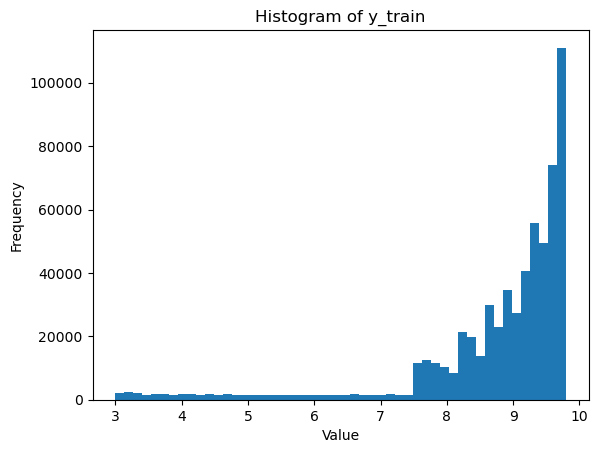

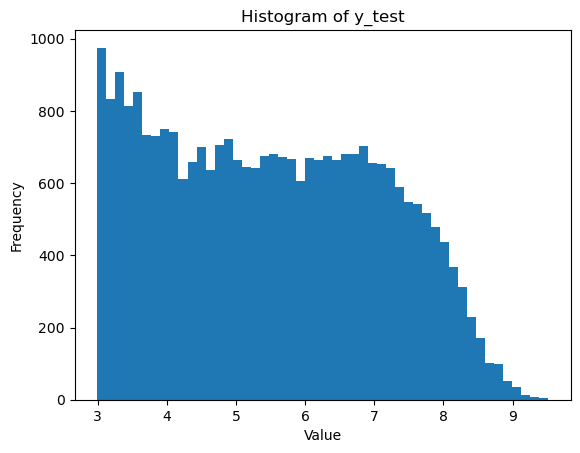

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用Matplotlib绘制直方图
plt.hist(y_train[:, -1].flatten(), bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# 使用Matplotlib绘制直方图
plt.hist(y_test[:, -1].flatten(), bins=50)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### 训练

In [16]:
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
# train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train_normalized))

# train_data = TensorDataset(torch.tensor(X_train_new), torch.tensor(y_train_new))
# test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test_normalized))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((610731, 10, 7), (610731, 1), (27812, 10, 7), (27812, 1))

In [30]:
X_train[0][0], y_train[0], X_test[0][0], y_test[0]

(array([ 1.       ,  1.       ,  0.       , -0.1264639,  0.       ,
         0.       ,  0.1      ]),
 array([-0.23140678]),
 array([ 1.        ,  1.        ,  0.        , -0.21835563,  0.        ,
         0.        ,  0.5       ]),
 array([-0.21028333]))

In [88]:
y_test[20]

array([2.94443903])

d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
train epoch 0: 100%|██████████| 9543/9543 [00:43<00:00, 221.83batch/s]


Epoch 1/500, Train Loss: 0.30405443817701877, Validation Loss: 20.934698363556258 Current learning rate: 5e-05


train epoch 1: 100%|██████████| 9543/9543 [00:47<00:00, 201.12batch/s]


Epoch 2/500, Train Loss: 0.28311836613410674, Validation Loss: 20.468036210948025 Current learning rate: 5e-05


train epoch 2: 100%|██████████| 9543/9543 [01:29<00:00, 107.17batch/s]


Epoch 3/500, Train Loss: 0.2752968873131841, Validation Loss: 20.014190932525985 Current learning rate: 5e-05


train epoch 3: 100%|██████████| 9543/9543 [01:29<00:00, 106.09batch/s]


Epoch 4/500, Train Loss: 0.2707967437069071, Validation Loss: 19.715287607565692 Current learning rate: 5e-05


train epoch 4: 100%|██████████| 9543/9543 [01:29<00:00, 106.59batch/s]


Epoch 5/500, Train Loss: 0.2671366466601028, Validation Loss: 19.668894215287832 Current learning rate: 5e-05


train epoch 5: 100%|██████████| 9543/9543 [01:29<00:00, 106.43batch/s]


Epoch 6/500, Train Loss: 0.26353693251700744, Validation Loss: 18.666793827626897 Current learning rate: 5e-05


train epoch 6: 100%|██████████| 9543/9543 [01:29<00:00, 106.27batch/s]


Epoch 7/500, Train Loss: 0.26019249583604165, Validation Loss: 19.55348426117294 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 7: 100%|██████████| 9543/9543 [01:29<00:00, 106.83batch/s]


Epoch 8/500, Train Loss: 0.2566809782128495, Validation Loss: 18.426379024023298 Current learning rate: 5e-05


train epoch 8: 100%|██████████| 9543/9543 [01:19<00:00, 120.25batch/s]


Epoch 9/500, Train Loss: 0.2532488123725436, Validation Loss: 17.553943270102316 Current learning rate: 5e-05


train epoch 9: 100%|██████████| 9543/9543 [00:42<00:00, 224.68batch/s]


Epoch 10/500, Train Loss: 0.24972262345453508, Validation Loss: 18.40928373665645 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 10: 100%|██████████| 9543/9543 [00:42<00:00, 224.58batch/s]


Epoch 11/500, Train Loss: 0.2468435763297785, Validation Loss: 17.776038441712828 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 11: 100%|██████████| 9543/9543 [00:42<00:00, 225.91batch/s]


Epoch 12/500, Train Loss: 0.24433137060115825, Validation Loss: 17.29369063980278 Current learning rate: 5e-05


train epoch 12: 100%|██████████| 9543/9543 [00:42<00:00, 226.18batch/s]


Epoch 13/500, Train Loss: 0.2399492697353247, Validation Loss: 17.161255619443697 Current learning rate: 5e-05


train epoch 13: 100%|██████████| 9543/9543 [00:42<00:00, 224.95batch/s]


Epoch 14/500, Train Loss: 0.23756990063223876, Validation Loss: 16.60494441109142 Current learning rate: 5e-05


train epoch 14: 100%|██████████| 9543/9543 [00:42<00:00, 225.25batch/s]


Epoch 15/500, Train Loss: 0.23410873416505568, Validation Loss: 16.455694354265585 Current learning rate: 5e-05


train epoch 15: 100%|██████████| 9543/9543 [00:42<00:00, 226.31batch/s]


Epoch 16/500, Train Loss: 0.23222735080640422, Validation Loss: 16.42026252746582 Current learning rate: 5e-05


train epoch 16: 100%|██████████| 9543/9543 [00:42<00:00, 226.17batch/s]


Epoch 17/500, Train Loss: 0.22854206018968848, Validation Loss: 16.00267909915968 Current learning rate: 5e-05


train epoch 17: 100%|██████████| 9543/9543 [00:42<00:00, 226.06batch/s]


Epoch 18/500, Train Loss: 0.2252112992805067, Validation Loss: 16.804365000231513 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 18: 100%|██████████| 9543/9543 [00:42<00:00, 225.73batch/s]


Epoch 19/500, Train Loss: 0.2240321702234752, Validation Loss: 16.326124064127605 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 19: 100%|██████████| 9543/9543 [00:42<00:00, 224.21batch/s]


Epoch 20/500, Train Loss: 0.22011029584028619, Validation Loss: 15.973976350104671 Current learning rate: 5e-05


train epoch 20: 100%|██████████| 9543/9543 [00:42<00:00, 224.99batch/s]


Epoch 21/500, Train Loss: 0.21798087087964707, Validation Loss: 16.774764183745987 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 21: 100%|██████████| 9543/9543 [00:42<00:00, 226.50batch/s]


Epoch 22/500, Train Loss: 0.2160298639548708, Validation Loss: 15.732090290113428 Current learning rate: 5e-05


train epoch 22: 100%|██████████| 9543/9543 [00:42<00:00, 226.17batch/s]


Epoch 23/500, Train Loss: 0.21304424325290947, Validation Loss: 15.936065287973689 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 23: 100%|██████████| 9543/9543 [00:42<00:00, 226.52batch/s]


Epoch 24/500, Train Loss: 0.21031511892704835, Validation Loss: 15.725122824482535 Current learning rate: 5e-05


train epoch 24: 100%|██████████| 9543/9543 [00:41<00:00, 227.27batch/s]


Epoch 25/500, Train Loss: 0.2076492434421994, Validation Loss: 15.929748642581632 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 25: 100%|██████████| 9543/9543 [00:42<00:00, 227.01batch/s]


Epoch 26/500, Train Loss: 0.20517383163917255, Validation Loss: 15.43208684373176 Current learning rate: 5e-05


train epoch 26: 100%|██████████| 9543/9543 [00:42<00:00, 225.59batch/s]


Epoch 27/500, Train Loss: 0.20269334710721423, Validation Loss: 15.877107442658524 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 27: 100%|██████████| 9543/9543 [00:42<00:00, 223.97batch/s]


Epoch 28/500, Train Loss: 0.2004588325406931, Validation Loss: 15.112500114002447 Current learning rate: 5e-05


train epoch 28: 100%|██████████| 9543/9543 [00:42<00:00, 225.43batch/s]


Epoch 29/500, Train Loss: 0.19829251969071737, Validation Loss: 16.26196227238096 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 29: 100%|██████████| 9543/9543 [00:42<00:00, 226.24batch/s]


Epoch 30/500, Train Loss: 0.19680597402727681, Validation Loss: 15.264169614068393 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 30: 100%|██████████| 9543/9543 [00:42<00:00, 225.55batch/s]


Epoch 31/500, Train Loss: 0.1939080366830643, Validation Loss: 15.656269851772265 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 300


train epoch 31: 100%|██████████| 9543/9543 [00:42<00:00, 225.09batch/s]


Epoch 32/500, Train Loss: 0.19184495344559727, Validation Loss: 15.839563378520396 Current learning rate: 5e-05
EarlyStopping counter: 4 out of 300


train epoch 32: 100%|██████████| 9543/9543 [00:42<00:00, 227.05batch/s]


Epoch 33/500, Train Loss: 0.18968759246469544, Validation Loss: 14.871739021388963 Current learning rate: 5e-05


train epoch 33: 100%|██████████| 9543/9543 [01:14<00:00, 128.43batch/s]


Epoch 34/500, Train Loss: 0.18704231369104085, Validation Loss: 15.166681267749304 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 34: 100%|██████████| 9543/9543 [01:31<00:00, 103.94batch/s]


Epoch 35/500, Train Loss: 0.18492929845928122, Validation Loss: 14.36884586071146 Current learning rate: 5e-05


train epoch 35: 100%|██████████| 9543/9543 [01:31<00:00, 104.24batch/s]


Epoch 36/500, Train Loss: 0.1824064624104362, Validation Loss: 14.769338022429368 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 36: 100%|██████████| 9543/9543 [01:31<00:00, 104.38batch/s]


Epoch 37/500, Train Loss: 0.17994700091465782, Validation Loss: 14.679569531583239 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 37: 100%|██████████| 9543/9543 [01:31<00:00, 104.78batch/s]


Epoch 38/500, Train Loss: 0.17804234800816368, Validation Loss: 14.558484934664321 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 300


train epoch 38: 100%|██████████| 9543/9543 [01:32<00:00, 103.55batch/s]


Epoch 39/500, Train Loss: 0.1755382249663286, Validation Loss: 13.782181871348413 Current learning rate: 5e-05


train epoch 39: 100%|██████████| 9543/9543 [01:32<00:00, 103.29batch/s]


Epoch 40/500, Train Loss: 0.1739465692547536, Validation Loss: 14.011142239625427 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 40: 100%|██████████| 9543/9543 [01:32<00:00, 103.31batch/s]


Epoch 41/500, Train Loss: 0.17060083206764473, Validation Loss: 13.367234313350984 Current learning rate: 5e-05


train epoch 41: 100%|██████████| 9543/9543 [01:30<00:00, 105.47batch/s]


Epoch 42/500, Train Loss: 0.16948120617548287, Validation Loss: 13.514286475346006 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 42: 100%|██████████| 9543/9543 [01:31<00:00, 104.59batch/s]


Epoch 43/500, Train Loss: 0.16626019714618584, Validation Loss: 13.324779181644834 Current learning rate: 5e-05


train epoch 43: 100%|██████████| 9543/9543 [00:53<00:00, 178.91batch/s]


Epoch 44/500, Train Loss: 0.16478798504874703, Validation Loss: 12.991922523235452 Current learning rate: 5e-05


train epoch 44: 100%|██████████| 9543/9543 [00:42<00:00, 226.68batch/s]


Epoch 45/500, Train Loss: 0.1617074407021117, Validation Loss: 13.16248112821031 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 45: 100%|██████████| 9543/9543 [00:41<00:00, 227.34batch/s]


Epoch 46/500, Train Loss: 0.16077926509428964, Validation Loss: 12.588194312172375 Current learning rate: 5e-05


train epoch 46: 100%|██████████| 9543/9543 [00:41<00:00, 228.26batch/s]


Epoch 47/500, Train Loss: 0.15755208862829692, Validation Loss: 12.421947799331841 Current learning rate: 5e-05


train epoch 47: 100%|██████████| 9543/9543 [00:42<00:00, 227.09batch/s]


Epoch 48/500, Train Loss: 0.15620120011081107, Validation Loss: 12.36417933716171 Current learning rate: 5e-05


train epoch 48: 100%|██████████| 9543/9543 [00:42<00:00, 225.95batch/s]


Epoch 49/500, Train Loss: 0.1532953190080018, Validation Loss: 12.065374659395767 Current learning rate: 5e-05


train epoch 49: 100%|██████████| 9543/9543 [00:42<00:00, 225.40batch/s]


Epoch 50/500, Train Loss: 0.15169465835494594, Validation Loss: 12.023699056691138 Current learning rate: 5e-05


train epoch 50: 100%|██████████| 9543/9543 [00:42<00:00, 226.48batch/s]


Epoch 51/500, Train Loss: 0.14904764367798976, Validation Loss: 11.816467090036678 Current learning rate: 5e-05


train epoch 51: 100%|██████████| 9543/9543 [00:42<00:00, 226.68batch/s]


Epoch 52/500, Train Loss: 0.14730562772541336, Validation Loss: 11.94145844777425 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 52: 100%|██████████| 9543/9543 [00:41<00:00, 227.64batch/s]


Epoch 53/500, Train Loss: 0.14495702770419663, Validation Loss: 11.433093388875326 Current learning rate: 5e-05


train epoch 53: 100%|██████████| 9543/9543 [00:42<00:00, 227.06batch/s]


Epoch 54/500, Train Loss: 0.14318185111769907, Validation Loss: 11.467284007456112 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 54: 100%|██████████| 9543/9543 [00:42<00:00, 226.93batch/s]


Epoch 55/500, Train Loss: 0.14061005000073049, Validation Loss: 11.274402712679457 Current learning rate: 5e-05


train epoch 55: 100%|██████████| 9543/9543 [00:41<00:00, 227.71batch/s]


Epoch 56/500, Train Loss: 0.13873756406738, Validation Loss: 11.204249920242134 Current learning rate: 5e-05


train epoch 56: 100%|██████████| 9543/9543 [00:42<00:00, 227.12batch/s]


Epoch 57/500, Train Loss: 0.13632677274647903, Validation Loss: 11.056944158707543 Current learning rate: 5e-05


train epoch 57: 100%|██████████| 9543/9543 [00:42<00:00, 226.39batch/s]


Epoch 58/500, Train Loss: 0.13470324312827534, Validation Loss: 10.938899748352751 Current learning rate: 5e-05


train epoch 58: 100%|██████████| 9543/9543 [00:42<00:00, 224.89batch/s]


Epoch 59/500, Train Loss: 0.13262641291515354, Validation Loss: 10.820465267663714 Current learning rate: 5e-05


train epoch 59: 100%|██████████| 9543/9543 [00:41<00:00, 227.44batch/s]


Epoch 60/500, Train Loss: 0.13047859046569563, Validation Loss: 10.935827421867984 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 60: 100%|██████████| 9543/9543 [00:42<00:00, 227.18batch/s]


Epoch 61/500, Train Loss: 0.12820489110935912, Validation Loss: 10.58103376914715 Current learning rate: 5e-05


train epoch 61: 100%|██████████| 9543/9543 [00:42<00:00, 226.84batch/s]


Epoch 62/500, Train Loss: 0.12594761109336966, Validation Loss: 10.530233462103482 Current learning rate: 5e-05


train epoch 62: 100%|██████████| 9543/9543 [00:41<00:00, 227.37batch/s]


Epoch 63/500, Train Loss: 0.12363812171998613, Validation Loss: 9.997275549789954 Current learning rate: 5e-05


train epoch 63: 100%|██████████| 9543/9543 [00:41<00:00, 227.74batch/s]


Epoch 64/500, Train Loss: 0.12163003754715093, Validation Loss: 9.970397904275478 Current learning rate: 5e-05


train epoch 64: 100%|██████████| 9543/9543 [00:41<00:00, 227.51batch/s]


Epoch 65/500, Train Loss: 0.11942919439750452, Validation Loss: 9.883525909774605 Current learning rate: 5e-05


train epoch 65: 100%|██████████| 9543/9543 [00:42<00:00, 225.95batch/s]


Epoch 66/500, Train Loss: 0.11727717287386022, Validation Loss: 9.958553241861278 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 66: 100%|██████████| 9543/9543 [00:42<00:00, 225.59batch/s]


Epoch 67/500, Train Loss: 0.11518690790836618, Validation Loss: 10.05218382649038 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 67: 100%|██████████| 9543/9543 [00:42<00:00, 227.14batch/s]


Epoch 68/500, Train Loss: 0.11308184823615239, Validation Loss: 9.966064852133565 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 300


train epoch 68: 100%|██████████| 9543/9543 [00:42<00:00, 226.40batch/s]


Epoch 69/500, Train Loss: 0.1112760439411471, Validation Loss: 9.678409928288954 Current learning rate: 5e-05


train epoch 69: 100%|██████████| 9543/9543 [00:42<00:00, 226.97batch/s]


Epoch 70/500, Train Loss: 0.1095272697606708, Validation Loss: 9.716383136003866 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 70: 100%|██████████| 9543/9543 [00:42<00:00, 226.69batch/s]


Epoch 71/500, Train Loss: 0.10725035484396932, Validation Loss: 9.61922873902595 Current learning rate: 5e-05


train epoch 71: 100%|██████████| 9543/9543 [00:41<00:00, 228.23batch/s]


Epoch 72/500, Train Loss: 0.1052717392163139, Validation Loss: 9.654108346741776 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 72: 100%|██████████| 9543/9543 [00:41<00:00, 227.52batch/s]


Epoch 73/500, Train Loss: 0.1038862173770017, Validation Loss: 9.606705387159325 Current learning rate: 5e-05


train epoch 73: 100%|██████████| 9543/9543 [00:42<00:00, 226.89batch/s]


Epoch 74/500, Train Loss: 0.10187887747387622, Validation Loss: 9.398879480910027 Current learning rate: 5e-05


train epoch 74: 100%|██████████| 9543/9543 [00:42<00:00, 226.86batch/s]


Epoch 75/500, Train Loss: 0.10003731083556233, Validation Loss: 9.252261125630346 Current learning rate: 5e-05


train epoch 75: 100%|██████████| 9543/9543 [00:42<00:00, 225.27batch/s]


Epoch 76/500, Train Loss: 0.09820195073670769, Validation Loss: 9.212082724735655 Current learning rate: 5e-05


train epoch 76: 100%|██████████| 9543/9543 [00:42<00:00, 226.96batch/s]


Epoch 77/500, Train Loss: 0.09725348973268297, Validation Loss: 9.152605644313768 Current learning rate: 5e-05


train epoch 77: 100%|██████████| 9543/9543 [00:42<00:00, 226.50batch/s]


Epoch 78/500, Train Loss: 0.09494426280596194, Validation Loss: 8.943501160062592 Current learning rate: 5e-05


train epoch 78: 100%|██████████| 9543/9543 [00:42<00:00, 227.13batch/s]


Epoch 79/500, Train Loss: 0.09300416207105354, Validation Loss: 8.83835463030585 Current learning rate: 5e-05


train epoch 79: 100%|██████████| 9543/9543 [00:42<00:00, 226.39batch/s]


Epoch 80/500, Train Loss: 0.0911310054501377, Validation Loss: 8.617029119908125 Current learning rate: 5e-05


train epoch 80: 100%|██████████| 9543/9543 [00:42<00:00, 226.68batch/s]


Epoch 81/500, Train Loss: 0.08929821178669378, Validation Loss: 8.847888190170814 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 81: 100%|██████████| 9543/9543 [00:42<00:00, 226.96batch/s]


Epoch 82/500, Train Loss: 0.08773776955185664, Validation Loss: 8.808906488308962 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 82: 100%|██████████| 9543/9543 [00:42<00:00, 225.07batch/s]


Epoch 83/500, Train Loss: 0.08610209028727359, Validation Loss: 8.730524192459281 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 300


train epoch 83: 100%|██████████| 9543/9543 [00:42<00:00, 225.34batch/s]


Epoch 84/500, Train Loss: 0.0844164312629584, Validation Loss: 8.699143075394904 Current learning rate: 5e-05
EarlyStopping counter: 4 out of 300


train epoch 84: 100%|██████████| 9543/9543 [00:42<00:00, 226.41batch/s]


Epoch 85/500, Train Loss: 0.08300323070166589, Validation Loss: 8.530258941650391 Current learning rate: 5e-05


train epoch 85: 100%|██████████| 9543/9543 [00:42<00:00, 226.93batch/s]


Epoch 86/500, Train Loss: 0.08090672714181536, Validation Loss: 8.447240924835205 Current learning rate: 5e-05


train epoch 86: 100%|██████████| 9543/9543 [00:41<00:00, 227.23batch/s]


Epoch 87/500, Train Loss: 0.07905467903761877, Validation Loss: 8.249690897711393 Current learning rate: 5e-05


train epoch 87: 100%|██████████| 9543/9543 [00:42<00:00, 226.50batch/s]


Epoch 88/500, Train Loss: 0.0777587722630237, Validation Loss: 8.243007675258593 Current learning rate: 5e-05


train epoch 88: 100%|██████████| 9543/9543 [00:41<00:00, 228.41batch/s]


Epoch 89/500, Train Loss: 0.07582812895705582, Validation Loss: 8.429140245503392 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 300


train epoch 89: 100%|██████████| 9543/9543 [00:42<00:00, 226.94batch/s]


Epoch 90/500, Train Loss: 0.07435030319720053, Validation Loss: 8.38075637707765 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 300


train epoch 90: 100%|██████████| 9543/9543 [00:42<00:00, 225.87batch/s]


Epoch 91/500, Train Loss: 0.07279322623900494, Validation Loss: 8.36215436540801 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 300


train epoch 91: 100%|██████████| 9543/9543 [00:42<00:00, 225.62batch/s]


Epoch 92/500, Train Loss: 0.07177017580326067, Validation Loss: 8.3335809543215 Current learning rate: 5e-05
EarlyStopping counter: 4 out of 300


train epoch 92: 100%|██████████| 9543/9543 [00:42<00:00, 226.48batch/s]


Epoch 93/500, Train Loss: 0.07004808761189402, Validation Loss: 8.2418571373512 Current learning rate: 5e-05


train epoch 93: 100%|██████████| 9543/9543 [00:41<00:00, 227.32batch/s]


Epoch 94/500, Train Loss: 0.0686020335732675, Validation Loss: 8.306857389691233 Current learning rate: 5e-05
EarlyStopping counter: 5 out of 300


train epoch 94: 100%|██████████| 9543/9543 [00:42<00:00, 226.90batch/s]


Epoch 95/500, Train Loss: 0.06719304123743283, Validation Loss: 8.366780819289986 Current learning rate: 5e-05
EarlyStopping counter: 6 out of 300


train epoch 95: 100%|██████████| 9543/9543 [00:41<00:00, 227.58batch/s]


Epoch 96/500, Train Loss: 0.06628629507091068, Validation Loss: 8.425511942238643 Current learning rate: 5e-05
EarlyStopping counter: 7 out of 300


train epoch 96: 100%|██████████| 9543/9543 [00:41<00:00, 227.71batch/s]


Epoch 97/500, Train Loss: 0.0649011358847346, Validation Loss: 8.486539042681112 Current learning rate: 5e-05
EarlyStopping counter: 8 out of 300


train epoch 97: 100%|██████████| 9543/9543 [00:41<00:00, 228.25batch/s]


Epoch 98/500, Train Loss: 0.06413762315369563, Validation Loss: 8.495365890415236 Current learning rate: 5e-05
EarlyStopping counter: 9 out of 300


train epoch 98: 100%|██████████| 9543/9543 [00:41<00:00, 228.12batch/s]


Epoch 99/500, Train Loss: 0.0625902454704341, Validation Loss: 8.593890056390872 Current learning rate: 5e-05
EarlyStopping counter: 10 out of 300


train epoch 99: 100%|██████████| 9543/9543 [00:42<00:00, 226.58batch/s]


Epoch 100/500, Train Loss: 0.061748512030501954, Validation Loss: 8.57893458180044 Current learning rate: 5e-05
EarlyStopping counter: 11 out of 300


train epoch 100: 100%|██████████| 9543/9543 [00:42<00:00, 224.96batch/s]


Epoch 101/500, Train Loss: 0.06044756040646264, Validation Loss: 8.699821531361547 Current learning rate: 5e-05
EarlyStopping counter: 12 out of 300


train epoch 101: 100%|██████████| 9543/9543 [00:42<00:00, 225.99batch/s]


Epoch 102/500, Train Loss: 0.05968869324727389, Validation Loss: 8.604018866878816 Current learning rate: 5e-05
EarlyStopping counter: 13 out of 300


train epoch 102: 100%|██████████| 9543/9543 [00:42<00:00, 226.73batch/s]


Epoch 103/500, Train Loss: 0.058599478978410724, Validation Loss: 8.746332601569165 Current learning rate: 5e-05
EarlyStopping counter: 14 out of 300


train epoch 103: 100%|██████████| 9543/9543 [00:42<00:00, 226.92batch/s]


Epoch 104/500, Train Loss: 0.05780394265972164, Validation Loss: 8.678755829252045 Current learning rate: 5e-05
EarlyStopping counter: 15 out of 300


train epoch 104: 100%|██████████| 9543/9543 [00:42<00:00, 226.24batch/s]


Epoch 105/500, Train Loss: 0.05646287379256446, Validation Loss: 8.93529167613764 Current learning rate: 5e-05
EarlyStopping counter: 16 out of 300


train epoch 105: 100%|██████████| 9543/9543 [00:41<00:00, 227.73batch/s]


Epoch 106/500, Train Loss: 0.056675836707766034, Validation Loss: 9.45039354850506 Current learning rate: 5e-05
EarlyStopping counter: 17 out of 300


train epoch 106: 100%|██████████| 9543/9543 [00:41<00:00, 228.09batch/s]


Epoch 107/500, Train Loss: 0.05680711614493793, Validation Loss: 9.977220729301715 Current learning rate: 5e-05
EarlyStopping counter: 18 out of 300


train epoch 107: 100%|██████████| 9543/9543 [00:42<00:00, 226.26batch/s]


Epoch 108/500, Train Loss: 0.05678995986677742, Validation Loss: 9.515139436173714 Current learning rate: 5e-05
EarlyStopping counter: 19 out of 300


train epoch 108: 100%|██████████| 9543/9543 [00:42<00:00, 225.09batch/s]


Epoch 109/500, Train Loss: 0.055598423220060596, Validation Loss: 9.413592318830819 Current learning rate: 5e-05
EarlyStopping counter: 20 out of 300


train epoch 109: 100%|██████████| 9543/9543 [00:42<00:00, 226.04batch/s]


Epoch 110/500, Train Loss: 0.054111723732308645, Validation Loss: 9.267848476322218 Current learning rate: 5e-05
EarlyStopping counter: 21 out of 300


train epoch 110: 100%|██████████| 9543/9543 [00:42<00:00, 226.08batch/s]


Epoch 111/500, Train Loss: 0.053725823005656974, Validation Loss: 9.369451176435097 Current learning rate: 5e-05
EarlyStopping counter: 22 out of 300


train epoch 111: 100%|██████████| 9543/9543 [00:42<00:00, 226.74batch/s]


Epoch 112/500, Train Loss: 0.05323851191816709, Validation Loss: 9.3332582758761 Current learning rate: 5e-05
EarlyStopping counter: 23 out of 300


train epoch 112: 100%|██████████| 9543/9543 [00:41<00:00, 227.84batch/s]


Epoch 113/500, Train Loss: 0.0524407699468607, Validation Loss: 9.313565814358064 Current learning rate: 5e-05
EarlyStopping counter: 24 out of 300


train epoch 113: 100%|██████████| 9543/9543 [00:41<00:00, 228.17batch/s]


Epoch 114/500, Train Loss: 0.05159133917068689, Validation Loss: 9.170892257251959 Current learning rate: 5e-05
EarlyStopping counter: 25 out of 300


train epoch 114: 100%|██████████| 9543/9543 [00:41<00:00, 228.09batch/s]


Epoch 115/500, Train Loss: 0.05117234610526691, Validation Loss: 9.209394627055902 Current learning rate: 5e-05
EarlyStopping counter: 26 out of 300


train epoch 115: 100%|██████████| 9543/9543 [00:41<00:00, 227.36batch/s]


Epoch 116/500, Train Loss: 0.05086377716335008, Validation Loss: 9.024467046233429 Current learning rate: 5e-05
EarlyStopping counter: 27 out of 300


train epoch 116: 100%|██████████| 9543/9543 [00:42<00:00, 226.51batch/s]


Epoch 117/500, Train Loss: 0.049895934497516795, Validation Loss: 9.220439549150138 Current learning rate: 5e-05
EarlyStopping counter: 28 out of 300


train epoch 117: 100%|██████████| 9543/9543 [00:42<00:00, 225.70batch/s]


Epoch 118/500, Train Loss: 0.049585359866292096, Validation Loss: 9.189666333691827 Current learning rate: 5e-05
EarlyStopping counter: 29 out of 300


train epoch 118: 100%|██████████| 9543/9543 [00:42<00:00, 226.58batch/s]


Epoch 119/500, Train Loss: 0.048740198591133946, Validation Loss: 9.209251106744524 Current learning rate: 5e-05
EarlyStopping counter: 30 out of 300


train epoch 119: 100%|██████████| 9543/9543 [00:42<00:00, 227.16batch/s]


Epoch 120/500, Train Loss: 0.04875454285006539, Validation Loss: 9.328626553765659 Current learning rate: 5e-05
EarlyStopping counter: 31 out of 300


train epoch 120: 100%|██████████| 9543/9543 [00:42<00:00, 227.04batch/s]


Epoch 121/500, Train Loss: 0.04765475096354346, Validation Loss: 9.511458005576298 Current learning rate: 5e-05
EarlyStopping counter: 32 out of 300


train epoch 121: 100%|██████████| 9543/9543 [00:41<00:00, 231.20batch/s]


Epoch 122/500, Train Loss: 0.04742491823117287, Validation Loss: 9.597397363596949 Current learning rate: 5e-05
EarlyStopping counter: 33 out of 300


train epoch 122: 100%|██████████| 9543/9543 [00:41<00:00, 231.27batch/s]


Epoch 123/500, Train Loss: 0.0473951711418992, Validation Loss: 9.564089262074438 Current learning rate: 5e-05
EarlyStopping counter: 34 out of 300


train epoch 123: 100%|██████████| 9543/9543 [00:40<00:00, 233.57batch/s]


Epoch 124/500, Train Loss: 0.045893293217315945, Validation Loss: 9.61940012964709 Current learning rate: 5e-05
EarlyStopping counter: 35 out of 300


train epoch 124: 100%|██████████| 9543/9543 [00:40<00:00, 233.50batch/s]


Epoch 125/500, Train Loss: 0.04594678613292225, Validation Loss: 9.598414564680779 Current learning rate: 5e-05
EarlyStopping counter: 36 out of 300


train epoch 125: 100%|██████████| 9543/9543 [00:41<00:00, 231.26batch/s]


Epoch 126/500, Train Loss: 0.04509362651118363, Validation Loss: 9.612098534901937 Current learning rate: 5e-05
EarlyStopping counter: 37 out of 300


train epoch 126: 100%|██████████| 9543/9543 [00:41<00:00, 232.11batch/s]


Epoch 127/500, Train Loss: 0.0448643556075369, Validation Loss: 9.776748077348731 Current learning rate: 5e-05
EarlyStopping counter: 38 out of 300


train epoch 127: 100%|██████████| 9543/9543 [00:41<00:00, 231.50batch/s]


Epoch 128/500, Train Loss: 0.04402505207604865, Validation Loss: 9.66691653920316 Current learning rate: 5e-05
EarlyStopping counter: 39 out of 300


train epoch 128: 100%|██████████| 9543/9543 [00:41<00:00, 232.62batch/s]


Epoch 129/500, Train Loss: 0.042811315718552644, Validation Loss: 9.830984528859457 Current learning rate: 5e-05
EarlyStopping counter: 40 out of 300


train epoch 129: 100%|██████████| 9543/9543 [00:40<00:00, 233.06batch/s]


Epoch 130/500, Train Loss: 0.042836191700939615, Validation Loss: 9.886517593778413 Current learning rate: 5e-05
EarlyStopping counter: 41 out of 300


train epoch 130: 100%|██████████| 9543/9543 [00:40<00:00, 233.10batch/s]


Epoch 131/500, Train Loss: 0.04179185378303138, Validation Loss: 9.851473928868085 Current learning rate: 5e-05
EarlyStopping counter: 42 out of 300


train epoch 131: 100%|██████████| 9543/9543 [00:40<00:00, 233.09batch/s]


Epoch 132/500, Train Loss: 0.041607781427078314, Validation Loss: 9.911381503357285 Current learning rate: 5e-05
EarlyStopping counter: 43 out of 300


train epoch 132: 100%|██████████| 9543/9543 [00:40<00:00, 233.71batch/s]


Epoch 133/500, Train Loss: 0.04067341845289837, Validation Loss: 10.194788043800441 Current learning rate: 5e-05
EarlyStopping counter: 44 out of 300


train epoch 133: 100%|██████████| 9543/9543 [00:41<00:00, 232.60batch/s]


Epoch 134/500, Train Loss: 0.04073712181311063, Validation Loss: 10.129917881406588 Current learning rate: 5e-05
EarlyStopping counter: 45 out of 300


train epoch 134: 100%|██████████| 9543/9543 [00:41<00:00, 231.91batch/s]


Epoch 135/500, Train Loss: 0.040247100696621275, Validation Loss: 10.125514810934835 Current learning rate: 5e-05
EarlyStopping counter: 46 out of 300


train epoch 135: 100%|██████████| 9543/9543 [00:41<00:00, 232.26batch/s]


Epoch 136/500, Train Loss: 0.03964916206246028, Validation Loss: 10.173665245099999 Current learning rate: 5e-05
EarlyStopping counter: 47 out of 300


train epoch 136: 100%|██████████| 9543/9543 [00:41<00:00, 231.99batch/s]


Epoch 137/500, Train Loss: 0.03953027827775352, Validation Loss: 10.18929982569026 Current learning rate: 5e-05
EarlyStopping counter: 48 out of 300


train epoch 137: 100%|██████████| 9543/9543 [00:40<00:00, 233.10batch/s]


Epoch 138/500, Train Loss: 0.039743924026941393, Validation Loss: 10.137928718259964 Current learning rate: 5e-05
EarlyStopping counter: 49 out of 300


train epoch 138: 100%|██████████| 9543/9543 [00:40<00:00, 233.15batch/s]


Epoch 139/500, Train Loss: 0.03844844410567369, Validation Loss: 10.254639087326225 Current learning rate: 5e-05
EarlyStopping counter: 50 out of 300


train epoch 139: 100%|██████████| 9543/9543 [00:40<00:00, 233.36batch/s]


Epoch 140/500, Train Loss: 0.03806907224935631, Validation Loss: 10.261752850981965 Current learning rate: 5e-05
EarlyStopping counter: 51 out of 300


train epoch 140: 100%|██████████| 9543/9543 [00:40<00:00, 234.38batch/s]


Epoch 141/500, Train Loss: 0.038201140396892694, Validation Loss: 10.608797834111357 Current learning rate: 5e-05
EarlyStopping counter: 52 out of 300


train epoch 141: 100%|██████████| 9543/9543 [00:40<00:00, 232.90batch/s]


Epoch 142/500, Train Loss: 0.037101892811120606, Validation Loss: 10.36334603956376 Current learning rate: 5e-05
EarlyStopping counter: 53 out of 300


train epoch 142: 100%|██████████| 9543/9543 [00:41<00:00, 231.84batch/s]


Epoch 143/500, Train Loss: 0.03666413220255859, Validation Loss: 10.143555275051073 Current learning rate: 5e-05
EarlyStopping counter: 54 out of 300


train epoch 143: 100%|██████████| 9543/9543 [00:41<00:00, 232.44batch/s]


Epoch 144/500, Train Loss: 0.036535705149724026, Validation Loss: 10.226558355353344 Current learning rate: 5e-05
EarlyStopping counter: 55 out of 300


train epoch 144: 100%|██████████| 9543/9543 [00:41<00:00, 232.19batch/s]


Epoch 145/500, Train Loss: 0.0365665766589123, Validation Loss: 10.597985878209958 Current learning rate: 5e-05
EarlyStopping counter: 56 out of 300


train epoch 145: 100%|██████████| 9543/9543 [00:40<00:00, 232.92batch/s]


Epoch 146/500, Train Loss: 0.03629081559309238, Validation Loss: 10.424242735457147 Current learning rate: 5e-05
EarlyStopping counter: 57 out of 300


train epoch 146: 100%|██████████| 9543/9543 [00:41<00:00, 231.97batch/s]


Epoch 147/500, Train Loss: 0.035978778684559586, Validation Loss: 10.33011005226223 Current learning rate: 5e-05
EarlyStopping counter: 58 out of 300


train epoch 147: 100%|██████████| 9543/9543 [00:40<00:00, 233.22batch/s]


Epoch 148/500, Train Loss: 0.036692717196887506, Validation Loss: 10.254883475687311 Current learning rate: 5e-05
EarlyStopping counter: 59 out of 300


train epoch 148: 100%|██████████| 9543/9543 [00:40<00:00, 233.59batch/s]


Epoch 149/500, Train Loss: 0.036715427540466986, Validation Loss: 10.5996982278495 Current learning rate: 5e-05
EarlyStopping counter: 60 out of 300


train epoch 149: 100%|██████████| 9543/9543 [00:40<00:00, 233.70batch/s]


Epoch 150/500, Train Loss: 0.03632440120101873, Validation Loss: 10.328771882769706 Current learning rate: 5e-05
EarlyStopping counter: 61 out of 300


train epoch 150: 100%|██████████| 9543/9543 [00:41<00:00, 232.60batch/s]


Epoch 151/500, Train Loss: 0.03787177609147983, Validation Loss: 10.408794554348649 Current learning rate: 2e-05
EarlyStopping counter: 62 out of 300


train epoch 151: 100%|██████████| 9543/9543 [00:41<00:00, 231.71batch/s]


Epoch 152/500, Train Loss: 0.04695724792334397, Validation Loss: 9.506406572495385 Current learning rate: 2e-05
EarlyStopping counter: 63 out of 300


train epoch 152: 100%|██████████| 9543/9543 [00:41<00:00, 232.22batch/s]


Epoch 153/500, Train Loss: 0.040528910476296524, Validation Loss: 9.302917815899027 Current learning rate: 2e-05
EarlyStopping counter: 64 out of 300


train epoch 153: 100%|██████████| 9543/9543 [00:41<00:00, 232.12batch/s]


Epoch 154/500, Train Loss: 0.03777721538667959, Validation Loss: 9.165469283619146 Current learning rate: 2e-05
EarlyStopping counter: 65 out of 300


train epoch 154: 100%|██████████| 9543/9543 [00:41<00:00, 231.65batch/s]


Epoch 155/500, Train Loss: 0.03541938155210373, Validation Loss: 9.23627596888049 Current learning rate: 2e-05
EarlyStopping counter: 66 out of 300


train epoch 155: 100%|██████████| 9543/9543 [00:40<00:00, 232.94batch/s]


Epoch 156/500, Train Loss: 0.03370992756723893, Validation Loss: 9.249312880943561 Current learning rate: 2e-05
EarlyStopping counter: 67 out of 300


train epoch 156: 100%|██████████| 9543/9543 [00:40<00:00, 233.39batch/s]


Epoch 157/500, Train Loss: 0.032409071524554856, Validation Loss: 9.218618298673082 Current learning rate: 2e-05
EarlyStopping counter: 68 out of 300


train epoch 157: 100%|██████████| 9543/9543 [00:40<00:00, 233.82batch/s]


Epoch 158/500, Train Loss: 0.03108424132665613, Validation Loss: 9.25460106531779 Current learning rate: 2e-05
EarlyStopping counter: 69 out of 300


train epoch 158: 100%|██████████| 9543/9543 [00:40<00:00, 232.87batch/s]


Epoch 159/500, Train Loss: 0.029895774004642293, Validation Loss: 9.316624091137415 Current learning rate: 2e-05
EarlyStopping counter: 70 out of 300


train epoch 159: 100%|██████████| 9543/9543 [00:41<00:00, 232.54batch/s]


Epoch 160/500, Train Loss: 0.02934392690933303, Validation Loss: 9.340759023030598 Current learning rate: 2e-05
EarlyStopping counter: 71 out of 300


train epoch 160: 100%|██████████| 9543/9543 [00:40<00:00, 233.01batch/s]


Epoch 161/500, Train Loss: 0.028303188834120148, Validation Loss: 9.32711578018364 Current learning rate: 2e-05
EarlyStopping counter: 72 out of 300


train epoch 161: 100%|██████████| 9543/9543 [00:41<00:00, 232.63batch/s]


Epoch 162/500, Train Loss: 0.027425992594958277, Validation Loss: 9.383387432975331 Current learning rate: 2e-05
EarlyStopping counter: 73 out of 300


train epoch 162: 100%|██████████| 9543/9543 [00:41<00:00, 231.29batch/s]


Epoch 163/500, Train Loss: 0.02695599703690116, Validation Loss: 9.372115673415962 Current learning rate: 2e-05
EarlyStopping counter: 74 out of 300


train epoch 163: 100%|██████████| 9543/9543 [00:41<00:00, 232.38batch/s]


Epoch 164/500, Train Loss: 0.026497769679168778, Validation Loss: 9.417016953435438 Current learning rate: 2e-05
EarlyStopping counter: 75 out of 300


train epoch 164: 100%|██████████| 9543/9543 [00:41<00:00, 232.12batch/s]


Epoch 165/500, Train Loss: 0.025655053039266167, Validation Loss: 9.447244940132931 Current learning rate: 2e-05
EarlyStopping counter: 76 out of 300


train epoch 165: 100%|██████████| 9543/9543 [00:40<00:00, 233.26batch/s]


Epoch 166/500, Train Loss: 0.02520284920051894, Validation Loss: 9.454422101207163 Current learning rate: 2e-05
EarlyStopping counter: 77 out of 300


train epoch 166: 100%|██████████| 9543/9543 [00:40<00:00, 233.85batch/s]


Epoch 167/500, Train Loss: 0.024792143167581347, Validation Loss: 9.468013714099753 Current learning rate: 2e-05
EarlyStopping counter: 78 out of 300


train epoch 167: 100%|██████████| 9543/9543 [00:40<00:00, 232.99batch/s]


Epoch 168/500, Train Loss: 0.024107542695000154, Validation Loss: 9.505725091079185 Current learning rate: 2e-05
EarlyStopping counter: 79 out of 300


train epoch 168: 100%|██████████| 9543/9543 [00:41<00:00, 231.99batch/s]


Epoch 169/500, Train Loss: 0.023876277362020644, Validation Loss: 9.519610407160616 Current learning rate: 2e-05
EarlyStopping counter: 80 out of 300


train epoch 169: 100%|██████████| 9543/9543 [00:41<00:00, 231.39batch/s]


Epoch 170/500, Train Loss: 0.023331747477909517, Validation Loss: 9.581877476045456 Current learning rate: 2e-05
EarlyStopping counter: 81 out of 300


train epoch 170: 100%|██████████| 9543/9543 [00:41<00:00, 231.91batch/s]


Epoch 171/500, Train Loss: 0.023129800574471532, Validation Loss: 9.581623997085396 Current learning rate: 2e-05
EarlyStopping counter: 82 out of 300


train epoch 171: 100%|██████████| 9543/9543 [00:41<00:00, 232.37batch/s]


Epoch 172/500, Train Loss: 0.0225704248570779, Validation Loss: 9.626138481052443 Current learning rate: 2e-05
EarlyStopping counter: 83 out of 300


train epoch 172: 100%|██████████| 9543/9543 [00:41<00:00, 232.35batch/s]


Epoch 173/500, Train Loss: 0.022403739931618302, Validation Loss: 9.648541457077553 Current learning rate: 2e-05
EarlyStopping counter: 84 out of 300


train epoch 173: 100%|██████████| 9543/9543 [00:41<00:00, 232.27batch/s]


Epoch 174/500, Train Loss: 0.022094128698545882, Validation Loss: 9.683518413017536 Current learning rate: 2e-05
EarlyStopping counter: 85 out of 300


train epoch 174: 100%|██████████| 9543/9543 [00:40<00:00, 234.10batch/s]


Epoch 175/500, Train Loss: 0.021943982777557238, Validation Loss: 9.73172492542486 Current learning rate: 2e-05
EarlyStopping counter: 86 out of 300


train epoch 175: 100%|██████████| 9543/9543 [00:40<00:00, 233.24batch/s]


Epoch 176/500, Train Loss: 0.02139287704012154, Validation Loss: 9.784922299439879 Current learning rate: 2e-05
EarlyStopping counter: 87 out of 300


train epoch 176: 100%|██████████| 9543/9543 [00:40<00:00, 233.49batch/s]


Epoch 177/500, Train Loss: 0.021194992865187362, Validation Loss: 9.731155671744512 Current learning rate: 2e-05
EarlyStopping counter: 88 out of 300


train epoch 177: 100%|██████████| 9543/9543 [00:41<00:00, 231.86batch/s]


Epoch 178/500, Train Loss: 0.020972579673849225, Validation Loss: 9.796778108881808 Current learning rate: 2e-05
EarlyStopping counter: 89 out of 300


train epoch 178: 100%|██████████| 9543/9543 [00:41<00:00, 232.38batch/s]


Epoch 179/500, Train Loss: 0.020772241567406327, Validation Loss: 9.765454525783143 Current learning rate: 2e-05
EarlyStopping counter: 90 out of 300


train epoch 179: 100%|██████████| 9543/9543 [00:41<00:00, 232.62batch/s]


Epoch 180/500, Train Loss: 0.02034666565562697, Validation Loss: 9.86288943455137 Current learning rate: 2e-05
EarlyStopping counter: 91 out of 300


train epoch 180: 100%|██████████| 9543/9543 [00:40<00:00, 232.86batch/s]


Epoch 181/500, Train Loss: 0.020209950345554034, Validation Loss: 9.834731917545714 Current learning rate: 2e-05
EarlyStopping counter: 92 out of 300


train epoch 181: 100%|██████████| 9543/9543 [00:41<00:00, 232.08batch/s]


Epoch 182/500, Train Loss: 0.020154450262261033, Validation Loss: 9.878925207291527 Current learning rate: 2e-05
EarlyStopping counter: 93 out of 300


train epoch 182: 100%|██████████| 9543/9543 [00:40<00:00, 233.06batch/s]


Epoch 183/500, Train Loss: 0.019896059877614006, Validation Loss: 9.888682518882312 Current learning rate: 2e-05
EarlyStopping counter: 94 out of 300


train epoch 183: 100%|██████████| 9543/9543 [00:40<00:00, 233.87batch/s]


Epoch 184/500, Train Loss: 0.01979378792177044, Validation Loss: 9.816240883969712 Current learning rate: 2e-05
EarlyStopping counter: 95 out of 300


train epoch 184: 100%|██████████| 9543/9543 [00:40<00:00, 233.55batch/s]


Epoch 185/500, Train Loss: 0.019420948427957465, Validation Loss: 9.925097909466974 Current learning rate: 2e-05
EarlyStopping counter: 96 out of 300


train epoch 185: 100%|██████████| 9543/9543 [00:40<00:00, 232.92batch/s]


Epoch 186/500, Train Loss: 0.019409071882740398, Validation Loss: 9.891556832982205 Current learning rate: 2e-05
EarlyStopping counter: 97 out of 300


train epoch 186: 100%|██████████| 9543/9543 [00:41<00:00, 231.01batch/s]


Epoch 187/500, Train Loss: 0.019358795552810195, Validation Loss: 9.96320356829413 Current learning rate: 2e-05
EarlyStopping counter: 98 out of 300


train epoch 187: 100%|██████████| 9543/9543 [00:41<00:00, 232.47batch/s]


Epoch 188/500, Train Loss: 0.019045520583925984, Validation Loss: 9.959060746773906 Current learning rate: 2e-05
EarlyStopping counter: 99 out of 300


train epoch 188: 100%|██████████| 9543/9543 [00:41<00:00, 231.87batch/s]


Epoch 189/500, Train Loss: 0.018771361479560263, Validation Loss: 9.936620042515898 Current learning rate: 2e-05
EarlyStopping counter: 100 out of 300


train epoch 189: 100%|██████████| 9543/9543 [00:40<00:00, 232.95batch/s]


Epoch 190/500, Train Loss: 0.01879112881216854, Validation Loss: 9.921149100380383 Current learning rate: 2e-05
EarlyStopping counter: 101 out of 300


train epoch 190: 100%|██████████| 9543/9543 [00:41<00:00, 232.42batch/s]


Epoch 191/500, Train Loss: 0.018682261462208433, Validation Loss: 9.949822591365068 Current learning rate: 2e-05
EarlyStopping counter: 102 out of 300


train epoch 191: 100%|██████████| 9543/9543 [00:40<00:00, 233.59batch/s]


Epoch 192/500, Train Loss: 0.018361980798899082, Validation Loss: 9.937940664401 Current learning rate: 2e-05
EarlyStopping counter: 103 out of 300


train epoch 192: 100%|██████████| 9543/9543 [00:40<00:00, 232.87batch/s]


Epoch 193/500, Train Loss: 0.018267978545797404, Validation Loss: 9.954336496331226 Current learning rate: 2e-05
EarlyStopping counter: 104 out of 300


train epoch 193: 100%|██████████| 9543/9543 [00:40<00:00, 233.22batch/s]


Epoch 194/500, Train Loss: 0.01837850466045375, Validation Loss: 9.939880625406902 Current learning rate: 2e-05
EarlyStopping counter: 105 out of 300


train epoch 194: 100%|██████████| 9543/9543 [00:41<00:00, 231.68batch/s]


Epoch 195/500, Train Loss: 0.017967282833235877, Validation Loss: 9.930670818241163 Current learning rate: 2e-05
EarlyStopping counter: 106 out of 300


train epoch 195: 100%|██████████| 9543/9543 [00:41<00:00, 232.24batch/s]


Epoch 196/500, Train Loss: 0.017811486469332498, Validation Loss: 9.921297982095302 Current learning rate: 2e-05
EarlyStopping counter: 107 out of 300


train epoch 196: 100%|██████████| 9543/9543 [00:41<00:00, 231.87batch/s]


Epoch 197/500, Train Loss: 0.0176778553969934, Validation Loss: 9.884840046674356 Current learning rate: 2e-05
EarlyStopping counter: 108 out of 300


train epoch 197: 100%|██████████| 9543/9543 [00:41<00:00, 232.59batch/s]


Epoch 198/500, Train Loss: 0.01783697675992106, Validation Loss: 9.92808203971249 Current learning rate: 2e-05
EarlyStopping counter: 109 out of 300


train epoch 198: 100%|██████████| 9543/9543 [00:40<00:00, 233.47batch/s]


Epoch 199/500, Train Loss: 0.01782079939570007, Validation Loss: 9.888199825944572 Current learning rate: 2e-05
EarlyStopping counter: 110 out of 300


train epoch 199: 100%|██████████| 9543/9543 [00:41<00:00, 232.49batch/s]


Epoch 200/500, Train Loss: 0.0178593618432832, Validation Loss: 9.950793047060912 Current learning rate: 2e-05
EarlyStopping counter: 111 out of 300


train epoch 200: 100%|██████████| 9543/9543 [00:41<00:00, 232.72batch/s]


Epoch 201/500, Train Loss: 0.017693923068315052, Validation Loss: 9.903516282706425 Current learning rate: 8.000000000000001e-06
EarlyStopping counter: 112 out of 300


train epoch 201: 100%|██████████| 9543/9543 [00:41<00:00, 232.51batch/s]


Epoch 202/500, Train Loss: 0.03425366696277275, Validation Loss: 9.19854577272788 Current learning rate: 8.000000000000001e-06
EarlyStopping counter: 113 out of 300


train epoch 202: 100%|██████████| 9543/9543 [00:41<00:00, 232.28batch/s]


Epoch 203/500, Train Loss: 0.02970714004355421, Validation Loss: 9.08027292010428 Current learning rate: 8.000000000000001e-06
EarlyStopping counter: 114 out of 300


train epoch 203: 100%|██████████| 9543/9543 [00:41<00:00, 231.05batch/s]


Epoch 204/500, Train Loss: 0.028112620146023917, Validation Loss: 8.936366457226633 Current learning rate: 8.000000000000001e-06
EarlyStopping counter: 115 out of 300


train epoch 204: 100%|██████████| 9543/9543 [00:41<00:00, 232.04batch/s]


Epoch 205/500, Train Loss: 0.026589035538583397, Validation Loss: 8.873023406938575 Current learning rate: 3.2000000000000007e-06
EarlyStopping counter: 116 out of 300


train epoch 205: 100%|██████████| 9543/9543 [00:41<00:00, 231.98batch/s]


Epoch 206/500, Train Loss: 0.054293675112226235, Validation Loss: 8.3585934496474 Current learning rate: 3.2000000000000007e-06
EarlyStopping counter: 117 out of 300


train epoch 206: 100%|██████████| 9543/9543 [00:41<00:00, 232.54batch/s]


Epoch 207/500, Train Loss: 0.04912110318451362, Validation Loss: 8.270047400463586 Current learning rate: 3.2000000000000007e-06
EarlyStopping counter: 118 out of 300


train epoch 207: 100%|██████████| 9543/9543 [00:40<00:00, 232.77batch/s]


Epoch 208/500, Train Loss: 0.04696981121855345, Validation Loss: 8.139193612679668 Current learning rate: 3.2000000000000007e-06


train epoch 208: 100%|██████████| 9543/9543 [00:40<00:00, 234.07batch/s]


Epoch 209/500, Train Loss: 0.0449420484254606, Validation Loss: 8.044714001403458 Current learning rate: 1.2800000000000005e-06


train epoch 209: 100%|██████████| 9543/9543 [00:40<00:00, 233.66batch/s]


Epoch 210/500, Train Loss: 0.10598404355259479, Validation Loss: 6.56335677662115 Current learning rate: 1.2800000000000005e-06


train epoch 210: 100%|██████████| 9543/9543 [00:41<00:00, 232.34batch/s]


Epoch 211/500, Train Loss: 0.08178382290873303, Validation Loss: 6.690382853321646 Current learning rate: 1.2800000000000005e-06
EarlyStopping counter: 1 out of 300


train epoch 211: 100%|██████████| 9543/9543 [00:41<00:00, 231.77batch/s]


Epoch 212/500, Train Loss: 0.081680906527857, Validation Loss: 6.419341492926938 Current learning rate: 1.2800000000000005e-06


train epoch 212: 100%|██████████| 9543/9543 [00:41<00:00, 231.59batch/s]


Epoch 213/500, Train Loss: 0.0760667394402553, Validation Loss: 6.379919972913019 Current learning rate: 1e-06


train epoch 213: 100%|██████████| 9543/9543 [00:41<00:00, 231.11batch/s]


Epoch 214/500, Train Loss: 0.09292902626435781, Validation Loss: 5.670094172159831 Current learning rate: 1e-06


train epoch 214: 100%|██████████| 9543/9543 [00:41<00:00, 231.47batch/s]


Epoch 215/500, Train Loss: 0.08080969030990812, Validation Loss: 5.812462605005023 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 215: 100%|██████████| 9543/9543 [00:41<00:00, 231.89batch/s]


Epoch 216/500, Train Loss: 0.08135065697792573, Validation Loss: 5.641917424914481 Current learning rate: 1e-06


train epoch 216: 100%|██████████| 9543/9543 [00:41<00:00, 231.81batch/s]


Epoch 217/500, Train Loss: 0.07717153201671288, Validation Loss: 5.634210858947929 Current learning rate: 1e-06


train epoch 217: 100%|██████████| 9543/9543 [00:40<00:00, 234.02batch/s]


Epoch 218/500, Train Loss: 0.07557973497459579, Validation Loss: 5.573564821550216 Current learning rate: 1e-06


train epoch 218: 100%|██████████| 9543/9543 [00:40<00:00, 233.52batch/s]


Epoch 219/500, Train Loss: 0.07328850444225286, Validation Loss: 5.542048448255692 Current learning rate: 1e-06


train epoch 219: 100%|██████████| 9543/9543 [00:40<00:00, 232.89batch/s]


Epoch 220/500, Train Loss: 0.07180136161040884, Validation Loss: 5.5087786592286205 Current learning rate: 1e-06


train epoch 220: 100%|██████████| 9543/9543 [00:41<00:00, 231.80batch/s]


Epoch 221/500, Train Loss: 0.070250026221232, Validation Loss: 5.470564196027558 Current learning rate: 1e-06


train epoch 221: 100%|██████████| 9543/9543 [00:40<00:00, 233.49batch/s]


Epoch 222/500, Train Loss: 0.06850155222118456, Validation Loss: 5.444872275166128 Current learning rate: 1e-06


train epoch 222: 100%|██████████| 9543/9543 [00:41<00:00, 231.36batch/s]


Epoch 223/500, Train Loss: 0.06730255480261561, Validation Loss: 5.424740147316593 Current learning rate: 1e-06


train epoch 223: 100%|██████████| 9543/9543 [00:41<00:00, 232.49batch/s]


Epoch 224/500, Train Loss: 0.06609713311868153, Validation Loss: 5.3870468649370915 Current learning rate: 1e-06


train epoch 224: 100%|██████████| 9543/9543 [00:41<00:00, 232.13batch/s]


Epoch 225/500, Train Loss: 0.06469081510372353, Validation Loss: 5.36345750655251 Current learning rate: 1e-06


train epoch 225: 100%|██████████| 9543/9543 [00:40<00:00, 232.89batch/s]


Epoch 226/500, Train Loss: 0.063537400855088, Validation Loss: 5.353639678297371 Current learning rate: 1e-06


train epoch 226: 100%|██████████| 9543/9543 [00:41<00:00, 231.68batch/s]


Epoch 227/500, Train Loss: 0.06269628194031106, Validation Loss: 5.323653919395359 Current learning rate: 1e-06


train epoch 227: 100%|██████████| 9543/9543 [00:40<00:00, 233.23batch/s]


Epoch 228/500, Train Loss: 0.061330809616024586, Validation Loss: 5.29947437527536 Current learning rate: 1e-06


train epoch 228: 100%|██████████| 9543/9543 [00:41<00:00, 232.18batch/s]


Epoch 229/500, Train Loss: 0.060559997714603575, Validation Loss: 5.2830537806982285 Current learning rate: 1e-06


train epoch 229: 100%|██████████| 9543/9543 [00:41<00:00, 232.65batch/s]


Epoch 230/500, Train Loss: 0.0595348082945863, Validation Loss: 5.269229012522204 Current learning rate: 1e-06


train epoch 230: 100%|██████████| 9543/9543 [00:41<00:00, 231.91batch/s]


Epoch 231/500, Train Loss: 0.058745296521633086, Validation Loss: 5.25158361073198 Current learning rate: 1e-06


train epoch 231: 100%|██████████| 9543/9543 [00:41<00:00, 231.77batch/s]


Epoch 232/500, Train Loss: 0.05790795282091667, Validation Loss: 5.231605706269714 Current learning rate: 1e-06


train epoch 232: 100%|██████████| 9543/9543 [00:41<00:00, 231.07batch/s]


Epoch 233/500, Train Loss: 0.0573853423475784, Validation Loss: 5.219350277144334 Current learning rate: 1e-06


train epoch 233: 100%|██████████| 9543/9543 [00:41<00:00, 232.44batch/s]


Epoch 234/500, Train Loss: 0.056589492828885805, Validation Loss: 5.200602205320337 Current learning rate: 1e-06


train epoch 234: 100%|██████████| 9543/9543 [00:41<00:00, 232.73batch/s]


Epoch 235/500, Train Loss: 0.055574442517426284, Validation Loss: 5.197502245300117 Current learning rate: 1e-06


train epoch 235: 100%|██████████| 9543/9543 [00:40<00:00, 233.49batch/s]


Epoch 236/500, Train Loss: 0.05508367467623006, Validation Loss: 5.162109448443884 Current learning rate: 1e-06


train epoch 236: 100%|██████████| 9543/9543 [00:40<00:00, 233.02batch/s]


Epoch 237/500, Train Loss: 0.0543352785593441, Validation Loss: 5.157633183468347 Current learning rate: 1e-06


train epoch 237: 100%|██████████| 9543/9543 [00:40<00:00, 232.90batch/s]


Epoch 238/500, Train Loss: 0.0536929009241169, Validation Loss: 5.140415249199703 Current learning rate: 1e-06


train epoch 238: 100%|██████████| 9543/9543 [00:41<00:00, 231.72batch/s]


Epoch 239/500, Train Loss: 0.05308901094503454, Validation Loss: 5.1321520355926165 Current learning rate: 1e-06


train epoch 239: 100%|██████████| 9543/9543 [00:41<00:00, 232.10batch/s]


Epoch 240/500, Train Loss: 0.05245375046077915, Validation Loss: 5.117349935948163 Current learning rate: 1e-06


train epoch 240: 100%|██████████| 9543/9543 [00:41<00:00, 231.22batch/s]


Epoch 241/500, Train Loss: 0.05220101707627393, Validation Loss: 5.102571086773927 Current learning rate: 1e-06


train epoch 241: 100%|██████████| 9543/9543 [00:41<00:00, 231.83batch/s]


Epoch 242/500, Train Loss: 0.05151344534413842, Validation Loss: 5.091597569125822 Current learning rate: 1e-06


train epoch 242: 100%|██████████| 9543/9543 [00:41<00:00, 232.66batch/s]


Epoch 243/500, Train Loss: 0.05082928485845842, Validation Loss: 5.086982039199478 Current learning rate: 1e-06


train epoch 243: 100%|██████████| 9543/9543 [00:40<00:00, 233.93batch/s]


Epoch 244/500, Train Loss: 0.05008183420605078, Validation Loss: 5.062332419143326 Current learning rate: 1e-06


train epoch 244: 100%|██████████| 9543/9543 [00:40<00:00, 232.87batch/s]


Epoch 245/500, Train Loss: 0.049955148684816146, Validation Loss: 5.0554579504605 Current learning rate: 1e-06


train epoch 245: 100%|██████████| 9543/9543 [00:40<00:00, 232.92batch/s]


Epoch 246/500, Train Loss: 0.049176546809988494, Validation Loss: 5.04415205100487 Current learning rate: 1e-06


train epoch 246: 100%|██████████| 9543/9543 [00:41<00:00, 231.61batch/s]


Epoch 247/500, Train Loss: 0.04876814986203447, Validation Loss: 5.03884091103214 Current learning rate: 1e-06


train epoch 247: 100%|██████████| 9543/9543 [00:41<00:00, 232.53batch/s]


Epoch 248/500, Train Loss: 0.04831616053202965, Validation Loss: 5.024900537249685 Current learning rate: 1e-06


train epoch 248: 100%|██████████| 9543/9543 [00:41<00:00, 231.62batch/s]


Epoch 249/500, Train Loss: 0.04794246791716531, Validation Loss: 5.017792395339615 Current learning rate: 1e-06


train epoch 249: 100%|██████████| 9543/9543 [00:41<00:00, 232.23batch/s]


Epoch 250/500, Train Loss: 0.04744415338401806, Validation Loss: 5.0163943126283845 Current learning rate: 1e-06


train epoch 250: 100%|██████████| 9543/9543 [00:40<00:00, 233.82batch/s]


Epoch 251/500, Train Loss: 0.047300946046227164, Validation Loss: 4.990988935273269 Current learning rate: 1e-06


train epoch 251: 100%|██████████| 9543/9543 [00:40<00:00, 235.10batch/s]


Epoch 252/500, Train Loss: 0.04645159312923424, Validation Loss: 5.0042288336260565 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 252: 100%|██████████| 9543/9543 [00:40<00:00, 234.62batch/s]


Epoch 253/500, Train Loss: 0.04629785650600878, Validation Loss: 4.979310332769635 Current learning rate: 1e-06


train epoch 253: 100%|██████████| 9543/9543 [00:40<00:00, 233.47batch/s]


Epoch 254/500, Train Loss: 0.04574402137272205, Validation Loss: 4.9760617097218836 Current learning rate: 1e-06


train epoch 254: 100%|██████████| 9543/9543 [00:41<00:00, 232.52batch/s]


Epoch 255/500, Train Loss: 0.04562094786503496, Validation Loss: 4.9600386542835455 Current learning rate: 1e-06


train epoch 255: 100%|██████████| 9543/9543 [00:41<00:00, 232.58batch/s]


Epoch 256/500, Train Loss: 0.04514548646963354, Validation Loss: 4.956580229463248 Current learning rate: 1e-06


train epoch 256: 100%|██████████| 9543/9543 [00:40<00:00, 233.10batch/s]


Epoch 257/500, Train Loss: 0.04462981363489761, Validation Loss: 4.945851865856127 Current learning rate: 1e-06


train epoch 257: 100%|██████████| 9543/9543 [00:41<00:00, 232.25batch/s]


Epoch 258/500, Train Loss: 0.04433836007845309, Validation Loss: 4.942786849778274 Current learning rate: 1e-06


train epoch 258: 100%|██████████| 9543/9543 [00:40<00:00, 233.51batch/s]


Epoch 259/500, Train Loss: 0.04396564831546243, Validation Loss: 4.9307182070852695 Current learning rate: 1e-06


train epoch 259: 100%|██████████| 9543/9543 [00:40<00:00, 232.86batch/s]


Epoch 260/500, Train Loss: 0.043696710805800565, Validation Loss: 4.927205851434291 Current learning rate: 1e-06


train epoch 260: 100%|██████████| 9543/9543 [00:40<00:00, 234.13batch/s]


Epoch 261/500, Train Loss: 0.043117606640620094, Validation Loss: 4.900534217110995 Current learning rate: 1e-06


train epoch 261: 100%|██████████| 9543/9543 [00:40<00:00, 234.02batch/s]


Epoch 262/500, Train Loss: 0.04278272866503156, Validation Loss: 4.902263606279746 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 262: 100%|██████████| 9543/9543 [00:40<00:00, 233.48batch/s]


Epoch 263/500, Train Loss: 0.042438456318027847, Validation Loss: 4.896497607505185 Current learning rate: 1e-06


train epoch 263: 100%|██████████| 9543/9543 [00:41<00:00, 232.66batch/s]


Epoch 264/500, Train Loss: 0.042303841853299586, Validation Loss: 4.890765436764421 Current learning rate: 1e-06


train epoch 264: 100%|██████████| 9543/9543 [00:41<00:00, 232.67batch/s]


Epoch 265/500, Train Loss: 0.04163418938897667, Validation Loss: 4.899833555879264 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 265: 100%|██████████| 9543/9543 [00:41<00:00, 232.29batch/s]


Epoch 266/500, Train Loss: 0.04166429436316079, Validation Loss: 4.8693211051239365 Current learning rate: 1e-06


train epoch 266: 100%|██████████| 9543/9543 [00:40<00:00, 233.41batch/s]


Epoch 267/500, Train Loss: 0.04124358059120314, Validation Loss: 4.873093671360235 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 267: 100%|██████████| 9543/9543 [00:40<00:00, 233.27batch/s]


Epoch 268/500, Train Loss: 0.04081753420744053, Validation Loss: 4.861359161070023 Current learning rate: 1e-06


train epoch 268: 100%|██████████| 9543/9543 [00:40<00:00, 234.32batch/s]


Epoch 269/500, Train Loss: 0.040696519488946516, Validation Loss: 4.851251324839976 Current learning rate: 1e-06


train epoch 269: 100%|██████████| 9543/9543 [00:40<00:00, 235.01batch/s]


Epoch 270/500, Train Loss: 0.0404438697110036, Validation Loss: 4.864089041742785 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 270: 100%|██████████| 9543/9543 [00:40<00:00, 234.58batch/s]


Epoch 271/500, Train Loss: 0.04020831614629155, Validation Loss: 4.848090777451965 Current learning rate: 1e-06


train epoch 271: 100%|██████████| 9543/9543 [00:40<00:00, 234.20batch/s]


Epoch 272/500, Train Loss: 0.039877089309989545, Validation Loss: 4.84900066879974 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 272: 100%|██████████| 9543/9543 [00:41<00:00, 231.66batch/s]


Epoch 273/500, Train Loss: 0.039555238686737444, Validation Loss: 4.841708979113348 Current learning rate: 1e-06


train epoch 273: 100%|██████████| 9543/9543 [00:40<00:00, 233.28batch/s]


Epoch 274/500, Train Loss: 0.03914512180125167, Validation Loss: 4.836349658856447 Current learning rate: 1e-06


train epoch 274: 100%|██████████| 9543/9543 [00:41<00:00, 232.35batch/s]


Epoch 275/500, Train Loss: 0.038805603416218803, Validation Loss: 4.820536295024828 Current learning rate: 1e-06


train epoch 275: 100%|██████████| 9543/9543 [00:40<00:00, 233.74batch/s]


Epoch 276/500, Train Loss: 0.0386020228289333, Validation Loss: 4.816250253545827 Current learning rate: 1e-06


train epoch 276: 100%|██████████| 9543/9543 [00:40<00:00, 233.10batch/s]


Epoch 277/500, Train Loss: 0.038265921645192394, Validation Loss: 4.813756551961789 Current learning rate: 1e-06


train epoch 277: 100%|██████████| 9543/9543 [00:40<00:00, 234.58batch/s]


Epoch 278/500, Train Loss: 0.03807959051051081, Validation Loss: 4.805672476757532 Current learning rate: 1e-06


train epoch 278: 100%|██████████| 9543/9543 [00:40<00:00, 234.86batch/s]


Epoch 279/500, Train Loss: 0.03792791521364556, Validation Loss: 4.8091570607547105 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 279: 100%|██████████| 9543/9543 [00:40<00:00, 233.76batch/s]


Epoch 280/500, Train Loss: 0.03763982045092119, Validation Loss: 4.794432484966585 Current learning rate: 1e-06


train epoch 280: 100%|██████████| 9543/9543 [00:40<00:00, 233.64batch/s]


Epoch 281/500, Train Loss: 0.0374576625019926, Validation Loss: 4.789413527784676 Current learning rate: 1e-06


train epoch 281: 100%|██████████| 9543/9543 [00:40<00:00, 233.28batch/s]


Epoch 282/500, Train Loss: 0.03709069460448803, Validation Loss: 4.796886348176277 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 282: 100%|██████████| 9543/9543 [00:40<00:00, 232.95batch/s]


Epoch 283/500, Train Loss: 0.03706995750031479, Validation Loss: 4.771611390716728 Current learning rate: 1e-06


train epoch 283: 100%|██████████| 9543/9543 [00:40<00:00, 232.95batch/s]


Epoch 284/500, Train Loss: 0.03673975234624211, Validation Loss: 4.768463401136727 Current learning rate: 1e-06


train epoch 284: 100%|██████████| 9543/9543 [00:40<00:00, 232.79batch/s]


Epoch 285/500, Train Loss: 0.03636860358824372, Validation Loss: 4.778069078511205 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 285: 100%|██████████| 9543/9543 [00:40<00:00, 234.44batch/s]


Epoch 286/500, Train Loss: 0.036126485367342996, Validation Loss: 4.771455592122571 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 286: 100%|██████████| 9543/9543 [00:40<00:00, 234.17batch/s]


Epoch 287/500, Train Loss: 0.03613541926021765, Validation Loss: 4.767130230213033 Current learning rate: 1e-06


train epoch 287: 100%|██████████| 9543/9543 [00:40<00:00, 235.20batch/s]


Epoch 288/500, Train Loss: 0.035809517724914114, Validation Loss: 4.762713795694812 Current learning rate: 1e-06


train epoch 288: 100%|██████████| 9543/9543 [00:40<00:00, 234.66batch/s]


Epoch 289/500, Train Loss: 0.035576784261993365, Validation Loss: 4.762444176070992 Current learning rate: 1e-06


train epoch 289: 100%|██████████| 9543/9543 [00:40<00:00, 233.29batch/s]


Epoch 290/500, Train Loss: 0.03560639048020846, Validation Loss: 4.746722386897296 Current learning rate: 1e-06


train epoch 290: 100%|██████████| 9543/9543 [00:40<00:00, 233.00batch/s]


Epoch 291/500, Train Loss: 0.03509323386470959, Validation Loss: 4.752655643704294 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 291: 100%|██████████| 9543/9543 [00:41<00:00, 232.40batch/s]


Epoch 292/500, Train Loss: 0.03501905720571618, Validation Loss: 4.73462520413015 Current learning rate: 1e-06


train epoch 292: 100%|██████████| 9543/9543 [00:40<00:00, 234.13batch/s]


Epoch 293/500, Train Loss: 0.03459928404889292, Validation Loss: 4.755867340372896 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 293: 100%|██████████| 9543/9543 [00:40<00:00, 233.99batch/s]


Epoch 294/500, Train Loss: 0.034609967486596234, Validation Loss: 4.738226620904331 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 294: 100%|██████████| 9543/9543 [00:40<00:00, 233.92batch/s]


Epoch 295/500, Train Loss: 0.03433203560480441, Validation Loss: 4.742808377605745 Current learning rate: 1e-06
EarlyStopping counter: 3 out of 300


train epoch 295: 100%|██████████| 9543/9543 [00:40<00:00, 234.41batch/s]


Epoch 296/500, Train Loss: 0.03420642857391746, Validation Loss: 4.740759889558814 Current learning rate: 1e-06
EarlyStopping counter: 4 out of 300


train epoch 296: 100%|██████████| 9543/9543 [00:40<00:00, 233.59batch/s]


Epoch 297/500, Train Loss: 0.03398721033487268, Validation Loss: 4.721071301931622 Current learning rate: 1e-06


train epoch 297: 100%|██████████| 9543/9543 [00:40<00:00, 233.59batch/s]


Epoch 298/500, Train Loss: 0.0338862128809798, Validation Loss: 4.718371472961601 Current learning rate: 1e-06


train epoch 298: 100%|██████████| 9543/9543 [00:40<00:00, 233.56batch/s]


Epoch 299/500, Train Loss: 0.033506674800245814, Validation Loss: 4.741245752641524 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 299: 100%|██████████| 9543/9543 [00:40<00:00, 233.23batch/s]


Epoch 300/500, Train Loss: 0.03353740002330553, Validation Loss: 4.71540374920286 Current learning rate: 1e-06


train epoch 300: 100%|██████████| 9543/9543 [00:41<00:00, 232.47batch/s]


Epoch 301/500, Train Loss: 0.03303636168556341, Validation Loss: 4.7334889653085295 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 301: 100%|██████████| 9543/9543 [00:40<00:00, 233.21batch/s]


Epoch 302/500, Train Loss: 0.03307196876018306, Validation Loss: 4.722469714592243 Current learning rate: 1e-06
EarlyStopping counter: 3 out of 300


train epoch 302: 100%|██████████| 9543/9543 [00:40<00:00, 233.86batch/s]


Epoch 303/500, Train Loss: 0.03294096962704183, Validation Loss: 4.720988039038647 Current learning rate: 1e-06
EarlyStopping counter: 4 out of 300


train epoch 303: 100%|██████████| 9543/9543 [00:40<00:00, 233.82batch/s]


Epoch 304/500, Train Loss: 0.0326915375827061, Validation Loss: 4.716314065867457 Current learning rate: 1e-06
EarlyStopping counter: 5 out of 300


train epoch 304: 100%|██████████| 9543/9543 [00:40<00:00, 234.08batch/s]


Epoch 305/500, Train Loss: 0.03257307942083845, Validation Loss: 4.710184879960685 Current learning rate: 1e-06


train epoch 305: 100%|██████████| 9543/9543 [00:40<00:00, 233.95batch/s]


Epoch 306/500, Train Loss: 0.0323545382163428, Validation Loss: 4.708226734468306 Current learning rate: 1e-06


train epoch 306: 100%|██████████| 9543/9543 [00:40<00:00, 233.01batch/s]


Epoch 307/500, Train Loss: 0.03213418697902271, Validation Loss: 4.696155375995855 Current learning rate: 1e-06


train epoch 307: 100%|██████████| 9543/9543 [00:40<00:00, 232.82batch/s]


Epoch 308/500, Train Loss: 0.03191417509131764, Validation Loss: 4.704614245754549 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 308: 100%|██████████| 9543/9543 [00:40<00:00, 233.07batch/s]


Epoch 309/500, Train Loss: 0.03186464660742837, Validation Loss: 4.711409288713302 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 309: 100%|██████████| 9543/9543 [00:40<00:00, 233.64batch/s]


Epoch 310/500, Train Loss: 0.031784111416814316, Validation Loss: 4.702081546564211 Current learning rate: 1e-06
EarlyStopping counter: 3 out of 300


train epoch 310: 100%|██████████| 9543/9543 [00:40<00:00, 233.89batch/s]


Epoch 311/500, Train Loss: 0.03156647671293786, Validation Loss: 4.700789515725497 Current learning rate: 1e-06
EarlyStopping counter: 4 out of 300


train epoch 311: 100%|██████████| 9543/9543 [00:40<00:00, 234.47batch/s]


Epoch 312/500, Train Loss: 0.03142139745343202, Validation Loss: 4.691927307501606 Current learning rate: 1e-06


train epoch 312: 100%|██████████| 9543/9543 [00:40<00:00, 234.16batch/s]


Epoch 313/500, Train Loss: 0.031163267393894408, Validation Loss: 4.698622839478241 Current learning rate: 1e-06
EarlyStopping counter: 5 out of 300


train epoch 313: 100%|██████████| 9543/9543 [00:40<00:00, 234.47batch/s]


Epoch 314/500, Train Loss: 0.03113483304819122, Validation Loss: 4.6868417909775655 Current learning rate: 1e-06


train epoch 314: 100%|██████████| 9543/9543 [00:40<00:00, 233.40batch/s]


Epoch 315/500, Train Loss: 0.030782124503666734, Validation Loss: 4.690529149154137 Current learning rate: 1e-06
EarlyStopping counter: 6 out of 300


train epoch 315: 100%|██████████| 9543/9543 [00:41<00:00, 232.11batch/s]


Epoch 316/500, Train Loss: 0.030660411130235155, Validation Loss: 4.686729433892787 Current learning rate: 1e-06


train epoch 316: 100%|██████████| 9543/9543 [00:40<00:00, 233.10batch/s]


Epoch 317/500, Train Loss: 0.03066627654538879, Validation Loss: 4.69898809454907 Current learning rate: 1e-06
EarlyStopping counter: 7 out of 300


train epoch 317: 100%|██████████| 9543/9543 [00:40<00:00, 233.02batch/s]


Epoch 318/500, Train Loss: 0.030557544541634837, Validation Loss: 4.681578999552234 Current learning rate: 1e-06


train epoch 318: 100%|██████████| 9543/9543 [00:40<00:00, 234.08batch/s]


Epoch 319/500, Train Loss: 0.030291958504899123, Validation Loss: 4.671581369706954 Current learning rate: 1e-06


train epoch 319: 100%|██████████| 9543/9543 [00:40<00:00, 232.92batch/s]


Epoch 320/500, Train Loss: 0.029999623298986765, Validation Loss: 4.6828853102936145 Current learning rate: 1e-06
EarlyStopping counter: 8 out of 300


train epoch 320: 100%|██████████| 9543/9543 [00:40<00:00, 233.93batch/s]


Epoch 321/500, Train Loss: 0.030157754817122396, Validation Loss: 4.685143357309802 Current learning rate: 1e-06
EarlyStopping counter: 9 out of 300


train epoch 321: 100%|██████████| 9543/9543 [00:40<00:00, 234.59batch/s]


Epoch 322/500, Train Loss: 0.029884370708422734, Validation Loss: 4.677451509716867 Current learning rate: 1e-06
EarlyStopping counter: 10 out of 300


train epoch 322: 100%|██████████| 9543/9543 [00:40<00:00, 234.36batch/s]


Epoch 323/500, Train Loss: 0.029778537843980747, Validation Loss: 4.676230730407539 Current learning rate: 1e-06
EarlyStopping counter: 11 out of 300


train epoch 323: 100%|██████████| 9543/9543 [00:41<00:00, 232.67batch/s]


Epoch 324/500, Train Loss: 0.029646279849970425, Validation Loss: 4.663417566233668 Current learning rate: 1e-06


train epoch 324: 100%|██████████| 9543/9543 [00:40<00:00, 232.98batch/s]


Epoch 325/500, Train Loss: 0.02935038558816993, Validation Loss: 4.669975296108202 Current learning rate: 1e-06
EarlyStopping counter: 12 out of 300


train epoch 325: 100%|██████████| 9543/9543 [00:40<00:00, 234.11batch/s]


Epoch 326/500, Train Loss: 0.029241364264782726, Validation Loss: 4.664008157006625 Current learning rate: 1e-06
EarlyStopping counter: 13 out of 300


train epoch 326: 100%|██████████| 9543/9543 [00:40<00:00, 233.29batch/s]


Epoch 327/500, Train Loss: 0.02920629125523872, Validation Loss: 4.658904756348709 Current learning rate: 1e-06


train epoch 327: 100%|██████████| 9543/9543 [00:40<00:00, 233.26batch/s]


Epoch 328/500, Train Loss: 0.02899269239097224, Validation Loss: 4.6625328540802 Current learning rate: 1e-06
EarlyStopping counter: 14 out of 300


train epoch 328: 100%|██████████| 9543/9543 [00:40<00:00, 233.16batch/s]


Epoch 329/500, Train Loss: 0.028997223306408887, Validation Loss: 4.64953906453889 Current learning rate: 1e-06


train epoch 329: 100%|██████████| 9543/9543 [00:40<00:00, 234.15batch/s]


Epoch 330/500, Train Loss: 0.02866442211116642, Validation Loss: 4.644113974735655 Current learning rate: 1e-06


train epoch 330: 100%|██████████| 9543/9543 [00:40<00:00, 234.48batch/s]


Epoch 331/500, Train Loss: 0.028359637605857583, Validation Loss: 4.671760021407029 Current learning rate: 1e-06
EarlyStopping counter: 15 out of 300


train epoch 331: 100%|██████████| 9543/9543 [00:40<00:00, 233.22batch/s]


Epoch 332/500, Train Loss: 0.028568046386115407, Validation Loss: 4.648380241174808 Current learning rate: 1e-06
EarlyStopping counter: 16 out of 300


train epoch 332: 100%|██████████| 9543/9543 [00:41<00:00, 232.63batch/s]


Epoch 333/500, Train Loss: 0.0283029456476383, Validation Loss: 4.667621266156778 Current learning rate: 1e-06
EarlyStopping counter: 17 out of 300


train epoch 333: 100%|██████████| 9543/9543 [00:40<00:00, 232.85batch/s]


Epoch 334/500, Train Loss: 0.028390977813505806, Validation Loss: 4.635538043646977 Current learning rate: 1e-06


train epoch 334: 100%|██████████| 9543/9543 [00:40<00:00, 234.57batch/s]


Epoch 335/500, Train Loss: 0.02794222406595381, Validation Loss: 4.658880321458838 Current learning rate: 1e-06
EarlyStopping counter: 18 out of 300


train epoch 335: 100%|██████████| 9543/9543 [00:40<00:00, 232.98batch/s]


Epoch 336/500, Train Loss: 0.02807635339709528, Validation Loss: 4.651036390216872 Current learning rate: 1e-06
EarlyStopping counter: 19 out of 300


train epoch 336: 100%|██████████| 9543/9543 [00:40<00:00, 233.28batch/s]


Epoch 337/500, Train Loss: 0.027995826634188748, Validation Loss: 4.653482289149843 Current learning rate: 1e-06
EarlyStopping counter: 20 out of 300


train epoch 337: 100%|██████████| 9543/9543 [00:41<00:00, 232.60batch/s]


Epoch 338/500, Train Loss: 0.02773618103931279, Validation Loss: 4.627196779470334 Current learning rate: 1e-06


train epoch 338: 100%|██████████| 9543/9543 [00:40<00:00, 233.17batch/s]


Epoch 339/500, Train Loss: 0.027716684322470573, Validation Loss: 4.651054393834081 Current learning rate: 1e-06
EarlyStopping counter: 21 out of 300


train epoch 339: 100%|██████████| 9543/9543 [00:40<00:00, 234.74batch/s]


Epoch 340/500, Train Loss: 0.02758632611826792, Validation Loss: 4.63367992159964 Current learning rate: 1e-06
EarlyStopping counter: 22 out of 300


train epoch 340: 100%|██████████| 9543/9543 [00:40<00:00, 234.10batch/s]


Epoch 341/500, Train Loss: 0.027498462629564166, Validation Loss: 4.642668076767318 Current learning rate: 1e-06
EarlyStopping counter: 23 out of 300


train epoch 341: 100%|██████████| 9543/9543 [00:41<00:00, 232.74batch/s]


Epoch 342/500, Train Loss: 0.0272576524898054, Validation Loss: 4.639865084352165 Current learning rate: 1e-06
EarlyStopping counter: 24 out of 300


train epoch 342: 100%|██████████| 9543/9543 [00:41<00:00, 232.66batch/s]


Epoch 343/500, Train Loss: 0.02704685331120854, Validation Loss: 4.640109396528923 Current learning rate: 1e-06
EarlyStopping counter: 25 out of 300


train epoch 343: 100%|██████████| 9543/9543 [00:41<00:00, 232.18batch/s]


Epoch 344/500, Train Loss: 0.026949692741746085, Validation Loss: 4.633855767633723 Current learning rate: 1e-06
EarlyStopping counter: 26 out of 300


train epoch 344: 100%|██████████| 9543/9543 [00:41<00:00, 230.68batch/s]


Epoch 345/500, Train Loss: 0.027013238849301926, Validation Loss: 4.655013357359787 Current learning rate: 1e-06
EarlyStopping counter: 27 out of 300


train epoch 345: 100%|██████████| 9543/9543 [00:40<00:00, 233.47batch/s]


Epoch 346/500, Train Loss: 0.026984892109482, Validation Loss: 4.631062071898888 Current learning rate: 1e-06
EarlyStopping counter: 28 out of 300


train epoch 346: 100%|██████████| 9543/9543 [00:40<00:00, 233.43batch/s]


Epoch 347/500, Train Loss: 0.026765640519911107, Validation Loss: 4.64835253967636 Current learning rate: 1e-06
EarlyStopping counter: 29 out of 300


train epoch 347: 100%|██████████| 9543/9543 [00:40<00:00, 234.37batch/s]


Epoch 348/500, Train Loss: 0.026647607007117734, Validation Loss: 4.637150463016554 Current learning rate: 1e-06
EarlyStopping counter: 30 out of 300


train epoch 348: 100%|██████████| 9543/9543 [00:40<00:00, 233.62batch/s]


Epoch 349/500, Train Loss: 0.026542634363611824, Validation Loss: 4.621634273419435 Current learning rate: 1e-06


train epoch 349: 100%|██████████| 9543/9543 [00:40<00:00, 234.14batch/s]


Epoch 350/500, Train Loss: 0.02643189806926155, Validation Loss: 4.645574654655895 Current learning rate: 1e-06
EarlyStopping counter: 31 out of 300


train epoch 350: 100%|██████████| 9543/9543 [00:41<00:00, 232.43batch/s]


Epoch 351/500, Train Loss: 0.026323864128407853, Validation Loss: 4.615306991818308 Current learning rate: 1e-06


train epoch 351: 100%|██████████| 9543/9543 [00:41<00:00, 232.22batch/s]


Epoch 352/500, Train Loss: 0.02608664286990034, Validation Loss: 4.632148786522876 Current learning rate: 1e-06
EarlyStopping counter: 32 out of 300


train epoch 352: 100%|██████████| 9543/9543 [00:41<00:00, 232.49batch/s]


Epoch 353/500, Train Loss: 0.02609648428011024, Validation Loss: 4.640165719218638 Current learning rate: 1e-06
EarlyStopping counter: 33 out of 300


train epoch 353: 100%|██████████| 9543/9543 [00:40<00:00, 232.90batch/s]


Epoch 354/500, Train Loss: 0.026108439007548646, Validation Loss: 4.626416504520109 Current learning rate: 1e-06
EarlyStopping counter: 34 out of 300


train epoch 354: 100%|██████████| 9543/9543 [00:40<00:00, 232.95batch/s]


Epoch 355/500, Train Loss: 0.025848092977343713, Validation Loss: 4.620236218660727 Current learning rate: 1e-06
EarlyStopping counter: 35 out of 300


train epoch 355: 100%|██████████| 9543/9543 [00:40<00:00, 234.13batch/s]


Epoch 356/500, Train Loss: 0.025946205353737553, Validation Loss: 4.620500073487731 Current learning rate: 1e-06
EarlyStopping counter: 36 out of 300


train epoch 356: 100%|██████████| 9543/9543 [00:40<00:00, 233.99batch/s]


Epoch 357/500, Train Loss: 0.02568238985164105, Validation Loss: 4.620914605020107 Current learning rate: 1e-06
EarlyStopping counter: 37 out of 300


train epoch 357: 100%|██████████| 9543/9543 [00:40<00:00, 233.09batch/s]


Epoch 358/500, Train Loss: 0.025673871968950115, Validation Loss: 4.622653407063978 Current learning rate: 1e-06
EarlyStopping counter: 38 out of 300


train epoch 358: 100%|██████████| 9543/9543 [00:40<00:00, 232.85batch/s]


Epoch 359/500, Train Loss: 0.025454922767172865, Validation Loss: 4.613400595215546 Current learning rate: 1e-06


train epoch 359: 100%|██████████| 9543/9543 [00:40<00:00, 233.56batch/s]


Epoch 360/500, Train Loss: 0.025423920066333934, Validation Loss: 4.622975175682155 Current learning rate: 1e-06
EarlyStopping counter: 39 out of 300


train epoch 360: 100%|██████████| 9543/9543 [00:40<00:00, 233.81batch/s]


Epoch 361/500, Train Loss: 0.025324424637738048, Validation Loss: 4.614821946483919 Current learning rate: 1e-06
EarlyStopping counter: 40 out of 300


train epoch 361: 100%|██████████| 9543/9543 [00:40<00:00, 232.99batch/s]


Epoch 362/500, Train Loss: 0.025212135236393523, Validation Loss: 4.618430645164402 Current learning rate: 1e-06
EarlyStopping counter: 41 out of 300


train epoch 362: 100%|██████████| 9543/9543 [00:40<00:00, 233.91batch/s]


Epoch 363/500, Train Loss: 0.02517231631165406, Validation Loss: 4.6143212466404355 Current learning rate: 1e-06
EarlyStopping counter: 42 out of 300


train epoch 363: 100%|██████████| 9543/9543 [00:40<00:00, 233.92batch/s]


Epoch 364/500, Train Loss: 0.025145736251518818, Validation Loss: 4.612859991775162 Current learning rate: 1e-06


train epoch 364: 100%|██████████| 9543/9543 [00:40<00:00, 233.95batch/s]


Epoch 365/500, Train Loss: 0.024869573548797565, Validation Loss: 4.621437280479519 Current learning rate: 1e-06
EarlyStopping counter: 43 out of 300


train epoch 365: 100%|██████████| 9543/9543 [00:40<00:00, 234.78batch/s]


Epoch 366/500, Train Loss: 0.024954680057992104, Validation Loss: 4.613669206904269 Current learning rate: 1e-06
EarlyStopping counter: 44 out of 300


train epoch 366: 100%|██████████| 9543/9543 [00:40<00:00, 233.43batch/s]


Epoch 367/500, Train Loss: 0.024815830410870647, Validation Loss: 4.627286382105159 Current learning rate: 1e-06
EarlyStopping counter: 45 out of 300


train epoch 367: 100%|██████████| 9543/9543 [00:41<00:00, 232.54batch/s]


Epoch 368/500, Train Loss: 0.024619466843082024, Validation Loss: 4.617050458644998 Current learning rate: 1e-06
EarlyStopping counter: 46 out of 300


train epoch 368: 100%|██████████| 9543/9543 [00:40<00:00, 233.80batch/s]


Epoch 369/500, Train Loss: 0.02460077269738437, Validation Loss: 4.616017280227837 Current learning rate: 1e-06
EarlyStopping counter: 47 out of 300


train epoch 369: 100%|██████████| 9543/9543 [00:40<00:00, 232.96batch/s]


Epoch 370/500, Train Loss: 0.024538214867690852, Validation Loss: 4.597512276419278 Current learning rate: 1e-06


train epoch 370: 100%|██████████| 9543/9543 [00:40<00:00, 233.96batch/s]


Epoch 371/500, Train Loss: 0.024372881423750596, Validation Loss: 4.616341009907339 Current learning rate: 1e-06
EarlyStopping counter: 1 out of 300


train epoch 371: 100%|██████████| 9543/9543 [00:40<00:00, 232.77batch/s]


Epoch 372/500, Train Loss: 0.02441019230467671, Validation Loss: 4.599449549598256 Current learning rate: 1e-06
EarlyStopping counter: 2 out of 300


train epoch 372: 100%|██████████| 9543/9543 [00:40<00:00, 234.29batch/s]


Epoch 373/500, Train Loss: 0.02407522560719825, Validation Loss: 4.615546327349783 Current learning rate: 1e-06
EarlyStopping counter: 3 out of 300


train epoch 373: 100%|██████████| 9543/9543 [00:40<00:00, 234.84batch/s]


Epoch 374/500, Train Loss: 0.024116555645950884, Validation Loss: 4.610917124803039 Current learning rate: 1e-06
EarlyStopping counter: 4 out of 300


train epoch 374: 100%|██████████| 9543/9543 [00:40<00:00, 234.51batch/s]


Epoch 375/500, Train Loss: 0.02418441767708796, Validation Loss: 4.608361476591264 Current learning rate: 1e-06
EarlyStopping counter: 5 out of 300


train epoch 375: 100%|██████████| 9543/9543 [00:40<00:00, 234.45batch/s]


Epoch 376/500, Train Loss: 0.024092309063010374, Validation Loss: 4.619670019478633 Current learning rate: 1e-06
EarlyStopping counter: 6 out of 300


train epoch 376: 100%|██████████| 9543/9543 [00:40<00:00, 233.16batch/s]


Epoch 377/500, Train Loss: 0.023912299493728365, Validation Loss: 4.613326743553425 Current learning rate: 1e-06
EarlyStopping counter: 7 out of 300


train epoch 377: 100%|██████████| 9543/9543 [00:40<00:00, 233.49batch/s]


Epoch 378/500, Train Loss: 0.02408743537453617, Validation Loss: 4.605643548636601 Current learning rate: 1e-06
EarlyStopping counter: 8 out of 300


train epoch 378: 100%|██████████| 9543/9543 [00:40<00:00, 232.83batch/s]


Epoch 379/500, Train Loss: 0.023723629374759077, Validation Loss: 4.6028124239252906 Current learning rate: 1e-06
EarlyStopping counter: 9 out of 300


train epoch 379: 100%|██████████| 9543/9543 [00:40<00:00, 234.02batch/s]


Epoch 380/500, Train Loss: 0.02361326381625753, Validation Loss: 4.597607230043959 Current learning rate: 1e-06
EarlyStopping counter: 10 out of 300


train epoch 380: 100%|██████████| 9543/9543 [00:40<00:00, 233.80batch/s]


Epoch 381/500, Train Loss: 0.02360369495886814, Validation Loss: 4.5957200817678165 Current learning rate: 1e-06


train epoch 381: 100%|██████████| 9543/9543 [00:40<00:00, 234.36batch/s]


Epoch 382/500, Train Loss: 0.023451726010614824, Validation Loss: 4.6117425140293165 Current learning rate: 1e-06
EarlyStopping counter: 11 out of 300


train epoch 382: 100%|██████████| 9543/9543 [00:40<00:00, 234.19batch/s]


Epoch 383/500, Train Loss: 0.023535904414884234, Validation Loss: 4.607757580965415 Current learning rate: 1e-06
EarlyStopping counter: 12 out of 300


train epoch 383: 100%|██████████| 9543/9543 [00:40<00:00, 233.67batch/s]


Epoch 384/500, Train Loss: 0.02356555937474067, Validation Loss: 4.614463186812126 Current learning rate: 1e-06
EarlyStopping counter: 13 out of 300


train epoch 384: 100%|██████████| 9543/9543 [00:41<00:00, 232.58batch/s]


Epoch 385/500, Train Loss: 0.02336404515989664, Validation Loss: 4.59485134311106 Current learning rate: 1e-06


train epoch 385: 100%|██████████| 9543/9543 [00:41<00:00, 229.36batch/s]


Epoch 386/500, Train Loss: 0.02316644266452857, Validation Loss: 4.606237349016913 Current learning rate: 1e-06
EarlyStopping counter: 14 out of 300


train epoch 386: 100%|██████████| 9543/9543 [00:41<00:00, 232.71batch/s]


Epoch 387/500, Train Loss: 0.023117972798923886, Validation Loss: 4.606003431342114 Current learning rate: 1e-06
EarlyStopping counter: 15 out of 300


train epoch 387: 100%|██████████| 9543/9543 [00:40<00:00, 233.18batch/s]


Epoch 388/500, Train Loss: 0.023169049315628486, Validation Loss: 4.588350120084039 Current learning rate: 1e-06


train epoch 388: 100%|██████████| 9543/9543 [00:40<00:00, 233.46batch/s]


Epoch 389/500, Train Loss: 0.022879045523576932, Validation Loss: 4.591894275840672 Current learning rate: 1e-06
EarlyStopping counter: 16 out of 300


train epoch 389: 100%|██████████| 9543/9543 [00:40<00:00, 233.32batch/s]


Epoch 390/500, Train Loss: 0.022854166760179463, Validation Loss: 4.595727158140862 Current learning rate: 1e-06
EarlyStopping counter: 17 out of 300


train epoch 390: 100%|██████████| 9543/9543 [00:40<00:00, 233.68batch/s]


Epoch 391/500, Train Loss: 0.022850934593048253, Validation Loss: 4.5932259981659636 Current learning rate: 1e-06
EarlyStopping counter: 18 out of 300


train epoch 391: 100%|██████████| 9543/9543 [00:40<00:00, 234.29batch/s]


Epoch 392/500, Train Loss: 0.02279824675975849, Validation Loss: 4.594968633542115 Current learning rate: 1e-06
EarlyStopping counter: 19 out of 300


train epoch 392: 100%|██████████| 9543/9543 [00:40<00:00, 233.16batch/s]


Epoch 393/500, Train Loss: 0.022535400120063935, Validation Loss: 4.59211122140117 Current learning rate: 1e-06
EarlyStopping counter: 20 out of 300


train epoch 393: 100%|██████████| 9543/9543 [00:41<00:00, 232.65batch/s]


Epoch 394/500, Train Loss: 0.022559751099870462, Validation Loss: 4.608325597061508 Current learning rate: 1e-06
EarlyStopping counter: 21 out of 300


train epoch 394: 100%|██████████| 9543/9543 [00:41<00:00, 232.55batch/s]


Epoch 395/500, Train Loss: 0.022571802265448457, Validation Loss: 4.588487774750282 Current learning rate: 1e-06
EarlyStopping counter: 22 out of 300


train epoch 395: 100%|██████████| 9543/9543 [00:41<00:00, 232.60batch/s]


Epoch 396/500, Train Loss: 0.02249103261703132, Validation Loss: 4.596027680649154 Current learning rate: 1e-06
EarlyStopping counter: 23 out of 300


train epoch 396: 100%|██████████| 9543/9543 [00:40<00:00, 232.84batch/s]


Epoch 397/500, Train Loss: 0.022485400741521014, Validation Loss: 4.583056748598471 Current learning rate: 1e-06


train epoch 397: 100%|██████████| 9543/9543 [00:40<00:00, 236.05batch/s]


Epoch 398/500, Train Loss: 0.022423719851410548, Validation Loss: 4.578604476205234 Current learning rate: 1e-06


train epoch 398: 100%|██████████| 9543/9543 [00:40<00:00, 232.78batch/s]


Epoch 399/500, Train Loss: 0.0221735178740696, Validation Loss: 4.6033126507682365 Current learning rate: 1e-06
EarlyStopping counter: 24 out of 300


train epoch 399: 100%|██████████| 9543/9543 [00:40<00:00, 233.11batch/s]


Epoch 400/500, Train Loss: 0.022241933744446985, Validation Loss: 4.583440238031848 Current learning rate: 1e-06
EarlyStopping counter: 25 out of 300


train epoch 400: 100%|██████████| 9543/9543 [00:40<00:00, 233.27batch/s]


Epoch 401/500, Train Loss: 0.0220685165225198, Validation Loss: 4.5966639880476325 Current learning rate: 1e-06
EarlyStopping counter: 26 out of 300


train epoch 401: 100%|██████████| 9543/9543 [00:40<00:00, 233.42batch/s]


Epoch 402/500, Train Loss: 0.02214887263735576, Validation Loss: 4.581905643967376 Current learning rate: 1e-06
EarlyStopping counter: 27 out of 300


train epoch 402: 100%|██████████| 9543/9543 [00:41<00:00, 231.94batch/s]


Epoch 403/500, Train Loss: 0.022064323695620336, Validation Loss: 4.594200384205785 Current learning rate: 1e-06
EarlyStopping counter: 28 out of 300


train epoch 403: 100%|██████████| 9543/9543 [00:41<00:00, 232.38batch/s]


Epoch 404/500, Train Loss: 0.021728566393765174, Validation Loss: 4.5913926864492485 Current learning rate: 1e-06
EarlyStopping counter: 29 out of 300


train epoch 404: 100%|██████████| 9543/9543 [00:41<00:00, 232.39batch/s]


Epoch 405/500, Train Loss: 0.021820572332642948, Validation Loss: 4.587289649590678 Current learning rate: 1e-06
EarlyStopping counter: 30 out of 300


train epoch 405: 100%|██████████| 9543/9543 [00:40<00:00, 232.93batch/s]


Epoch 406/500, Train Loss: 0.021802228978929774, Validation Loss: 4.577276606395327 Current learning rate: 1e-06


train epoch 406: 100%|██████████| 9543/9543 [00:41<00:00, 232.40batch/s]


Epoch 407/500, Train Loss: 0.02177608850455638, Validation Loss: 4.58377693494161 Current learning rate: 1e-06
EarlyStopping counter: 31 out of 300


train epoch 407: 100%|██████████| 9543/9543 [00:40<00:00, 234.47batch/s]


Epoch 408/500, Train Loss: 0.021527554668809144, Validation Loss: 4.6036275551236905 Current learning rate: 1e-06
EarlyStopping counter: 32 out of 300


train epoch 408: 100%|██████████| 9543/9543 [00:40<00:00, 234.94batch/s]


Epoch 409/500, Train Loss: 0.021491522023739357, Validation Loss: 4.577389907836914 Current learning rate: 1e-06
EarlyStopping counter: 33 out of 300


train epoch 409: 100%|██████████| 9543/9543 [00:40<00:00, 233.71batch/s]


Epoch 410/500, Train Loss: 0.021394677744842126, Validation Loss: 4.583463701160475 Current learning rate: 1e-06
EarlyStopping counter: 34 out of 300


train epoch 410: 100%|██████████| 9543/9543 [00:41<00:00, 232.56batch/s]


Epoch 411/500, Train Loss: 0.021491210458842433, Validation Loss: 4.571834519813801 Current learning rate: 1e-06


train epoch 411: 100%|██████████| 9543/9543 [00:40<00:00, 233.61batch/s]


Epoch 412/500, Train Loss: 0.021244970097718207, Validation Loss: 4.593821277289555 Current learning rate: 1e-06
EarlyStopping counter: 35 out of 300


train epoch 412: 100%|██████████| 9543/9543 [00:40<00:00, 233.00batch/s]


Epoch 413/500, Train Loss: 0.021394033794964594, Validation Loss: 4.600105335520602 Current learning rate: 1e-06
EarlyStopping counter: 36 out of 300


train epoch 413: 100%|██████████| 9543/9543 [00:40<00:00, 233.28batch/s]


Epoch 414/500, Train Loss: 0.021266853453516976, Validation Loss: 4.598094098321322 Current learning rate: 1e-06
EarlyStopping counter: 37 out of 300


train epoch 414: 100%|██████████| 9543/9543 [00:41<00:00, 232.68batch/s]


Epoch 415/500, Train Loss: 0.021192337573402848, Validation Loss: 4.578324140351394 Current learning rate: 1e-06
EarlyStopping counter: 38 out of 300


train epoch 415: 100%|██████████| 9543/9543 [00:40<00:00, 234.06batch/s]


Epoch 416/500, Train Loss: 0.020981026004840315, Validation Loss: 4.590815879558694 Current learning rate: 1e-06
EarlyStopping counter: 39 out of 300


train epoch 416: 100%|██████████| 9543/9543 [00:40<00:00, 232.82batch/s]


Epoch 417/500, Train Loss: 0.02110637386598512, Validation Loss: 4.5893188060015095 Current learning rate: 1e-06
EarlyStopping counter: 40 out of 300


train epoch 417: 100%|██████████| 9543/9543 [00:40<00:00, 233.81batch/s]


Epoch 418/500, Train Loss: 0.021066174706707012, Validation Loss: 4.589935797110371 Current learning rate: 1e-06
EarlyStopping counter: 41 out of 300


train epoch 418: 100%|██████████| 9543/9543 [00:40<00:00, 233.07batch/s]


Epoch 419/500, Train Loss: 0.020941975708584255, Validation Loss: 4.586433367893614 Current learning rate: 1e-06
EarlyStopping counter: 42 out of 300


train epoch 419: 100%|██████████| 9543/9543 [00:41<00:00, 232.69batch/s]


Epoch 420/500, Train Loss: 0.020992332073367974, Validation Loss: 4.5733339517966085 Current learning rate: 1e-06
EarlyStopping counter: 43 out of 300


train epoch 420: 100%|██████████| 9543/9543 [00:41<00:00, 232.08batch/s]


Epoch 421/500, Train Loss: 0.02073743204018767, Validation Loss: 4.597745993493617 Current learning rate: 1e-06
EarlyStopping counter: 44 out of 300


train epoch 421: 100%|██████████| 9543/9543 [00:41<00:00, 232.30batch/s]


Epoch 422/500, Train Loss: 0.02073836991756668, Validation Loss: 4.598633114496867 Current learning rate: 1e-06
EarlyStopping counter: 45 out of 300


train epoch 422: 100%|██████████| 9543/9543 [00:41<00:00, 232.38batch/s]


Epoch 423/500, Train Loss: 0.020759837249306724, Validation Loss: 4.566010030658766 Current learning rate: 1e-06


train epoch 423: 100%|██████████| 9543/9543 [00:40<00:00, 234.05batch/s]


Epoch 424/500, Train Loss: 0.02049374757252925, Validation Loss: 4.5783541849289815 Current learning rate: 1e-06
EarlyStopping counter: 46 out of 300


train epoch 424: 100%|██████████| 9543/9543 [00:40<00:00, 233.76batch/s]


Epoch 425/500, Train Loss: 0.020735214765079404, Validation Loss: 4.565412351454811 Current learning rate: 1e-06


train epoch 425: 100%|██████████| 9543/9543 [00:40<00:00, 234.40batch/s]


Epoch 426/500, Train Loss: 0.020428514347619366, Validation Loss: 4.581585582097372 Current learning rate: 1e-06
EarlyStopping counter: 47 out of 300


train epoch 426: 100%|██████████| 9543/9543 [00:40<00:00, 233.71batch/s]


Epoch 427/500, Train Loss: 0.02041300020809774, Validation Loss: 4.5837415952792115 Current learning rate: 1e-06
EarlyStopping counter: 48 out of 300


train epoch 427: 100%|██████████| 9543/9543 [00:41<00:00, 232.37batch/s]


Epoch 428/500, Train Loss: 0.020366671177995326, Validation Loss: 4.580391738606595 Current learning rate: 1e-06
EarlyStopping counter: 49 out of 300


train epoch 428: 100%|██████████| 9543/9543 [00:41<00:00, 231.44batch/s]


Epoch 429/500, Train Loss: 0.02038630730958231, Validation Loss: 4.565093681181985 Current learning rate: 1e-06


train epoch 429: 100%|██████████| 9543/9543 [00:41<00:00, 232.72batch/s]


Epoch 430/500, Train Loss: 0.02014252140456793, Validation Loss: 4.580798834219746 Current learning rate: 1e-06
EarlyStopping counter: 50 out of 300


train epoch 430: 100%|██████████| 9543/9543 [00:41<00:00, 232.49batch/s]


Epoch 431/500, Train Loss: 0.020335986169314906, Validation Loss: 4.569676780700684 Current learning rate: 1e-06
EarlyStopping counter: 51 out of 300


train epoch 431: 100%|██████████| 9543/9543 [00:40<00:00, 233.00batch/s]


Epoch 432/500, Train Loss: 0.020275455065895842, Validation Loss: 4.573403644561767 Current learning rate: 1e-06
EarlyStopping counter: 52 out of 300


train epoch 432: 100%|██████████| 9543/9543 [00:40<00:00, 233.70batch/s]


Epoch 433/500, Train Loss: 0.020292546020595357, Validation Loss: 4.557253357459759 Current learning rate: 1e-06


train epoch 433: 100%|██████████| 9543/9543 [00:40<00:00, 233.90batch/s]


Epoch 434/500, Train Loss: 0.020062914051105843, Validation Loss: 4.593973596616723 Current learning rate: 1e-06
EarlyStopping counter: 53 out of 300


train epoch 434: 100%|██████████| 9543/9543 [00:40<00:00, 234.48batch/s]


Epoch 435/500, Train Loss: 0.02003777340524108, Validation Loss: 4.577488003105953 Current learning rate: 1e-06
EarlyStopping counter: 54 out of 300


train epoch 435: 100%|██████████| 9543/9543 [00:41<00:00, 232.70batch/s]


Epoch 436/500, Train Loss: 0.019979257978120914, Validation Loss: 4.577014718110534 Current learning rate: 1e-06
EarlyStopping counter: 55 out of 300


train epoch 436: 100%|██████████| 9543/9543 [00:41<00:00, 232.00batch/s]


Epoch 437/500, Train Loss: 0.019955454060351284, Validation Loss: 4.564077226046858 Current learning rate: 1e-06
EarlyStopping counter: 56 out of 300


train epoch 437: 100%|██████████| 9543/9543 [00:41<00:00, 232.69batch/s]


Epoch 438/500, Train Loss: 0.01984365700794175, Validation Loss: 4.581548107629535 Current learning rate: 1e-06
EarlyStopping counter: 57 out of 300


train epoch 438: 100%|██████████| 9543/9543 [00:41<00:00, 232.24batch/s]


Epoch 439/500, Train Loss: 0.01986044963866453, Validation Loss: 4.573985183650049 Current learning rate: 1e-06
EarlyStopping counter: 58 out of 300


train epoch 439: 100%|██████████| 9543/9543 [00:41<00:00, 232.49batch/s]


Epoch 440/500, Train Loss: 0.019719261863616472, Validation Loss: 4.578604356173812 Current learning rate: 1e-06
EarlyStopping counter: 59 out of 300


train epoch 440: 100%|██████████| 9543/9543 [00:41<00:00, 232.71batch/s]


Epoch 441/500, Train Loss: 0.01976432344810915, Validation Loss: 4.57620431582133 Current learning rate: 1e-06
EarlyStopping counter: 60 out of 300


train epoch 441: 100%|██████████| 9543/9543 [00:40<00:00, 233.22batch/s]


Epoch 442/500, Train Loss: 0.01956341441269663, Validation Loss: 4.572271052174185 Current learning rate: 1e-06
EarlyStopping counter: 61 out of 300


train epoch 442: 100%|██████████| 9543/9543 [00:40<00:00, 234.76batch/s]


Epoch 443/500, Train Loss: 0.019588591889888454, Validation Loss: 4.576846628627558 Current learning rate: 1e-06
EarlyStopping counter: 62 out of 300


train epoch 443: 100%|██████████| 9543/9543 [00:40<00:00, 233.94batch/s]


Epoch 444/500, Train Loss: 0.01954100964281656, Validation Loss: 4.587209195104139 Current learning rate: 1e-06
EarlyStopping counter: 63 out of 300


train epoch 444: 100%|██████████| 9543/9543 [00:40<00:00, 233.63batch/s]


Epoch 445/500, Train Loss: 0.019563204507780967, Validation Loss: 4.559580702617251 Current learning rate: 1e-06
EarlyStopping counter: 64 out of 300


train epoch 445: 100%|██████████| 9543/9543 [00:41<00:00, 232.57batch/s]


Epoch 446/500, Train Loss: 0.019336419507336007, Validation Loss: 4.58179139816898 Current learning rate: 1e-06
EarlyStopping counter: 65 out of 300


train epoch 446: 100%|██████████| 9543/9543 [00:40<00:00, 233.69batch/s]


Epoch 447/500, Train Loss: 0.01946033249871615, Validation Loss: 4.568216291515307 Current learning rate: 1e-06
EarlyStopping counter: 66 out of 300


train epoch 447: 100%|██████████| 9543/9543 [00:40<00:00, 232.96batch/s]


Epoch 448/500, Train Loss: 0.0193361325168002, Validation Loss: 4.563863892390811 Current learning rate: 1e-06
EarlyStopping counter: 67 out of 300


train epoch 448: 100%|██████████| 9543/9543 [00:41<00:00, 232.21batch/s]


Epoch 449/500, Train Loss: 0.019185390584053073, Validation Loss: 4.568963911341525 Current learning rate: 1e-06
EarlyStopping counter: 68 out of 300


train epoch 449: 100%|██████████| 9543/9543 [00:40<00:00, 233.22batch/s]


Epoch 450/500, Train Loss: 0.019268707555698487, Validation Loss: 4.5711587023461 Current learning rate: 1e-06
EarlyStopping counter: 69 out of 300


train epoch 450: 100%|██████████| 9543/9543 [00:40<00:00, 234.39batch/s]


Epoch 451/500, Train Loss: 0.019248740089685572, Validation Loss: 4.571041756662829 Current learning rate: 1e-06
EarlyStopping counter: 70 out of 300


train epoch 451: 100%|██████████| 9543/9543 [00:40<00:00, 234.33batch/s]


Epoch 452/500, Train Loss: 0.01901515964305862, Validation Loss: 4.5720794343400275 Current learning rate: 1e-06
EarlyStopping counter: 71 out of 300


train epoch 452: 100%|██████████| 9543/9543 [00:40<00:00, 234.20batch/s]


Epoch 453/500, Train Loss: 0.019174044649832068, Validation Loss: 4.54998458993846 Current learning rate: 1e-06


train epoch 453: 100%|██████████| 9543/9543 [00:40<00:00, 233.40batch/s]


Epoch 454/500, Train Loss: 0.01905795661857016, Validation Loss: 4.564033631072648 Current learning rate: 1e-06
EarlyStopping counter: 72 out of 300


train epoch 454: 100%|██████████| 9543/9543 [00:40<00:00, 233.57batch/s]


Epoch 455/500, Train Loss: 0.018984096989700674, Validation Loss: 4.560401141506502 Current learning rate: 1e-06
EarlyStopping counter: 73 out of 300


train epoch 455: 100%|██████████| 9543/9543 [00:40<00:00, 233.40batch/s]


Epoch 456/500, Train Loss: 0.018954957578407032, Validation Loss: 4.565750836229872 Current learning rate: 1e-06
EarlyStopping counter: 74 out of 300


train epoch 456: 100%|██████████| 9543/9543 [00:41<00:00, 232.23batch/s]


Epoch 457/500, Train Loss: 0.01886376156068118, Validation Loss: 4.5637009494606104 Current learning rate: 1e-06
EarlyStopping counter: 75 out of 300


train epoch 457: 100%|██████████| 9543/9543 [00:40<00:00, 233.08batch/s]


Epoch 458/500, Train Loss: 0.01883640428172539, Validation Loss: 4.562152601658613 Current learning rate: 1e-06
EarlyStopping counter: 76 out of 300


train epoch 458: 100%|██████████| 9543/9543 [00:40<00:00, 234.00batch/s]


Epoch 459/500, Train Loss: 0.018629860681956864, Validation Loss: 4.568294174369725 Current learning rate: 1e-06
EarlyStopping counter: 77 out of 300


train epoch 459: 100%|██████████| 9543/9543 [00:40<00:00, 234.28batch/s]


Epoch 460/500, Train Loss: 0.018838046524664174, Validation Loss: 4.550851997835883 Current learning rate: 1e-06
EarlyStopping counter: 78 out of 300


train epoch 460: 100%|██████████| 9543/9543 [00:40<00:00, 234.95batch/s]


Epoch 461/500, Train Loss: 0.01863965954391477, Validation Loss: 4.579279309305652 Current learning rate: 1e-06
EarlyStopping counter: 79 out of 300


train epoch 461: 100%|██████████| 9543/9543 [00:40<00:00, 234.38batch/s]


Epoch 462/500, Train Loss: 0.01875930928469986, Validation Loss: 4.552935467643299 Current learning rate: 1e-06
EarlyStopping counter: 80 out of 300


train epoch 462: 100%|██████████| 9543/9543 [00:40<00:00, 233.15batch/s]


Epoch 463/500, Train Loss: 0.018595920875082616, Validation Loss: 4.578654333640789 Current learning rate: 1e-06
EarlyStopping counter: 81 out of 300


train epoch 463: 100%|██████████| 9543/9543 [00:40<00:00, 232.81batch/s]


Epoch 464/500, Train Loss: 0.01858146642368668, Validation Loss: 4.5666464400017395 Current learning rate: 1e-06
EarlyStopping counter: 82 out of 300


train epoch 464: 100%|██████████| 9543/9543 [00:40<00:00, 232.84batch/s]


Epoch 465/500, Train Loss: 0.018605674102997256, Validation Loss: 4.5651239203310565 Current learning rate: 1e-06
EarlyStopping counter: 83 out of 300


train epoch 465: 100%|██████████| 9543/9543 [00:41<00:00, 232.62batch/s]


Epoch 466/500, Train Loss: 0.018429890833593292, Validation Loss: 4.558920677776994 Current learning rate: 1e-06
EarlyStopping counter: 84 out of 300


train epoch 466: 100%|██████████| 9543/9543 [00:40<00:00, 233.01batch/s]


Epoch 467/500, Train Loss: 0.018358860745240516, Validation Loss: 4.5525053435358505 Current learning rate: 1e-06
EarlyStopping counter: 85 out of 300


train epoch 467: 100%|██████████| 9543/9543 [00:40<00:00, 233.42batch/s]


Epoch 468/500, Train Loss: 0.018353211884226266, Validation Loss: 4.568309363551523 Current learning rate: 1e-06
EarlyStopping counter: 86 out of 300


train epoch 468: 100%|██████████| 9543/9543 [00:40<00:00, 234.40batch/s]


Epoch 469/500, Train Loss: 0.018267130935384183, Validation Loss: 4.58150392126763 Current learning rate: 1e-06
EarlyStopping counter: 87 out of 300


train epoch 469: 100%|██████████| 9543/9543 [00:40<00:00, 234.06batch/s]


Epoch 470/500, Train Loss: 0.01833164352852303, Validation Loss: 4.5633106176880585 Current learning rate: 1e-06
EarlyStopping counter: 88 out of 300


train epoch 470: 100%|██████████| 9543/9543 [00:41<00:00, 232.74batch/s]


Epoch 471/500, Train Loss: 0.018133488400092445, Validation Loss: 4.568661383376725 Current learning rate: 1e-06
EarlyStopping counter: 89 out of 300


train epoch 471: 100%|██████████| 9543/9543 [00:41<00:00, 232.35batch/s]


Epoch 472/500, Train Loss: 0.018434483459348845, Validation Loss: 4.567770360530107 Current learning rate: 1e-06
EarlyStopping counter: 90 out of 300


train epoch 472: 100%|██████████| 9543/9543 [00:40<00:00, 233.48batch/s]


Epoch 473/500, Train Loss: 0.01819063689002958, Validation Loss: 4.572813140934911 Current learning rate: 1e-06
EarlyStopping counter: 91 out of 300


train epoch 473: 100%|██████████| 9543/9543 [00:41<00:00, 232.31batch/s]


Epoch 474/500, Train Loss: 0.018179160450754846, Validation Loss: 4.56992403830605 Current learning rate: 1e-06
EarlyStopping counter: 92 out of 300


train epoch 474: 100%|██████████| 9543/9543 [00:40<00:00, 232.85batch/s]


Epoch 475/500, Train Loss: 0.01795330376251317, Validation Loss: 4.565766972508924 Current learning rate: 1e-06
EarlyStopping counter: 93 out of 300


train epoch 475: 100%|██████████| 9543/9543 [00:40<00:00, 233.53batch/s]


Epoch 476/500, Train Loss: 0.01795093470496127, Validation Loss: 4.562906776077446 Current learning rate: 1e-06
EarlyStopping counter: 94 out of 300


train epoch 476: 100%|██████████| 9543/9543 [00:40<00:00, 233.81batch/s]


Epoch 477/500, Train Loss: 0.017986035257680614, Validation Loss: 4.554583312725199 Current learning rate: 1e-06
EarlyStopping counter: 95 out of 300


train epoch 477: 100%|██████████| 9543/9543 [00:40<00:00, 234.77batch/s]


Epoch 478/500, Train Loss: 0.017930812130049913, Validation Loss: 4.557849503659654 Current learning rate: 1e-06
EarlyStopping counter: 96 out of 300


train epoch 478: 100%|██████████| 9543/9543 [00:40<00:00, 234.50batch/s]


Epoch 479/500, Train Loss: 0.017848829699186802, Validation Loss: 4.566004559637486 Current learning rate: 1e-06
EarlyStopping counter: 97 out of 300


train epoch 479: 100%|██████████| 9543/9543 [00:40<00:00, 233.58batch/s]


Epoch 480/500, Train Loss: 0.01801803583731344, Validation Loss: 4.545147475428965 Current learning rate: 1e-06


train epoch 480: 100%|██████████| 9543/9543 [00:40<00:00, 233.42batch/s]


Epoch 481/500, Train Loss: 0.01786162434392522, Validation Loss: 4.562519742702616 Current learning rate: 1e-06
EarlyStopping counter: 98 out of 300


train epoch 481: 100%|██████████| 9543/9543 [00:40<00:00, 233.70batch/s]


Epoch 482/500, Train Loss: 0.017869473154539565, Validation Loss: 4.556043704350789 Current learning rate: 1e-06
EarlyStopping counter: 99 out of 300


train epoch 482: 100%|██████████| 9543/9543 [00:41<00:00, 231.60batch/s]


Epoch 483/500, Train Loss: 0.017725115333426238, Validation Loss: 4.572055073990219 Current learning rate: 1e-06
EarlyStopping counter: 100 out of 300


train epoch 483: 100%|██████████| 9543/9543 [00:41<00:00, 232.44batch/s]


Epoch 484/500, Train Loss: 0.017828707928999415, Validation Loss: 4.568084989745041 Current learning rate: 1e-06
EarlyStopping counter: 101 out of 300


train epoch 484: 100%|██████████| 9543/9543 [00:41<00:00, 232.62batch/s]


Epoch 485/500, Train Loss: 0.017778594350472222, Validation Loss: 4.555745989152755 Current learning rate: 1e-06
EarlyStopping counter: 102 out of 300


train epoch 485: 100%|██████████| 9543/9543 [00:41<00:00, 232.18batch/s]


Epoch 486/500, Train Loss: 0.017755178187990432, Validation Loss: 4.559138627435969 Current learning rate: 1e-06
EarlyStopping counter: 103 out of 300


train epoch 486: 100%|██████████| 9543/9543 [00:40<00:00, 233.50batch/s]


Epoch 487/500, Train Loss: 0.01756290856377122, Validation Loss: 4.57292036133251 Current learning rate: 1e-06
EarlyStopping counter: 104 out of 300


train epoch 487: 100%|██████████| 9543/9543 [00:40<00:00, 233.13batch/s]


Epoch 488/500, Train Loss: 0.017503274929329116, Validation Loss: 4.56527200676929 Current learning rate: 1e-06
EarlyStopping counter: 105 out of 300


train epoch 488: 100%|██████████| 9543/9543 [00:40<00:00, 233.02batch/s]


Epoch 489/500, Train Loss: 0.017430192851871442, Validation Loss: 4.552456919900302 Current learning rate: 1e-06
EarlyStopping counter: 106 out of 300


train epoch 489: 100%|██████████| 9543/9543 [00:41<00:00, 232.69batch/s]


Epoch 490/500, Train Loss: 0.017458126309307112, Validation Loss: 4.564266202093541 Current learning rate: 1e-06
EarlyStopping counter: 107 out of 300


train epoch 490: 100%|██████████| 9543/9543 [00:41<00:00, 232.24batch/s]


Epoch 491/500, Train Loss: 0.017429722959822067, Validation Loss: 4.565165624947383 Current learning rate: 1e-06
EarlyStopping counter: 108 out of 300


train epoch 491: 100%|██████████| 9543/9543 [00:41<00:00, 232.72batch/s]


Epoch 492/500, Train Loss: 0.01738893790946987, Validation Loss: 4.5546612745043875 Current learning rate: 1e-06
EarlyStopping counter: 109 out of 300


train epoch 492: 100%|██████████| 9543/9543 [00:41<00:00, 232.46batch/s]


Epoch 493/500, Train Loss: 0.017358837234572683, Validation Loss: 4.558749332647214 Current learning rate: 1e-06
EarlyStopping counter: 110 out of 300


train epoch 493: 100%|██████████| 9543/9543 [00:40<00:00, 233.52batch/s]


Epoch 494/500, Train Loss: 0.01730419932536847, Validation Loss: 4.56391110858698 Current learning rate: 1e-06
EarlyStopping counter: 111 out of 300


train epoch 494: 100%|██████████| 9543/9543 [00:40<00:00, 233.07batch/s]


Epoch 495/500, Train Loss: 0.01732194225768537, Validation Loss: 4.556773310694202 Current learning rate: 1e-06
EarlyStopping counter: 112 out of 300


train epoch 495: 100%|██████████| 9543/9543 [00:40<00:00, 233.72batch/s]


Epoch 496/500, Train Loss: 0.01719475568662144, Validation Loss: 4.57067564986218 Current learning rate: 1e-06
EarlyStopping counter: 113 out of 300


train epoch 496: 100%|██████████| 9543/9543 [00:40<00:00, 233.55batch/s]


Epoch 497/500, Train Loss: 0.017313795961516245, Validation Loss: 4.551428674281328 Current learning rate: 1e-06
EarlyStopping counter: 114 out of 300


train epoch 497: 100%|██████████| 9543/9543 [00:41<00:00, 232.60batch/s]


Epoch 498/500, Train Loss: 0.017014362915806477, Validation Loss: 4.573430966782844 Current learning rate: 1e-06
EarlyStopping counter: 115 out of 300


train epoch 498: 100%|██████████| 9543/9543 [00:41<00:00, 232.07batch/s]


Epoch 499/500, Train Loss: 0.01712943099968302, Validation Loss: 4.558243382662192 Current learning rate: 1e-06
EarlyStopping counter: 116 out of 300


train epoch 499: 100%|██████████| 9543/9543 [00:41<00:00, 232.47batch/s]


Epoch 500/500, Train Loss: 0.017145560943756015, Validation Loss: 4.553782201087338 Current learning rate: 1e-06
EarlyStopping counter: 117 out of 300


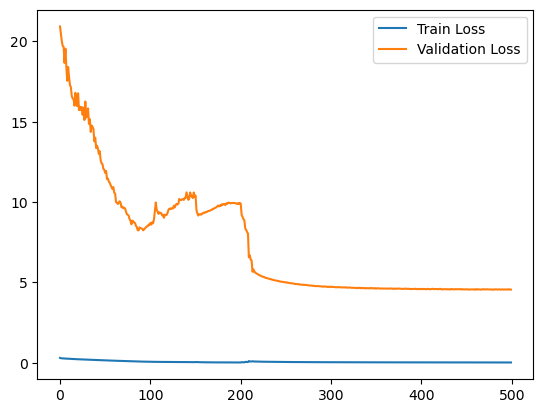

Epoch 500/500, Train Loss: 0.017145560943756015, Validation Loss: 4.553782201087338
Test RMSE: 2.1337755
CPU times: total: 30min 33s
Wall time: 6h 3min 20s


In [17]:
%%time
from torch.nn.parallel import DataParallel
import torch.nn.functional as F

hidden_size = 256
num_layers = 2
batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
 
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out
    
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.softmax = nn.Softmax(dim=1)  # Use softmax for multi-class classification

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Initialize cell state
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         # Apply softmax to the output layer
#         out = self.softmax(out)
#         return out
    
# LSTM_SelfAttention model
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1)
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1)
        # output的形状是(batch_size, hidden_size)
        return output
    
# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# BiLSTM-MAIN model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
        nn.init.xavier_uniform_(self.attention_heads)
        
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
        # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
        lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
        lstm_output = lstm_output.transpose(1, 2)
        # Compute attention scores
        attention_scores = torch.matmul(lstm_output, self.attention_heads)
        # Apply softmax to get the weights on the values
        attention_scores = F.softmax(attention_scores, dim=-2)
        # Apply attention weights to lstm_output
        weighted_output = attention_scores * lstm_output
        # Sum weighted output over seq_len dimension
        weighted_output = weighted_output.sum(dim=-2)
        # Reshape weighted_output to (batch_size, hidden_size)
        weighted_output = weighted_output.reshape(batch_size, -1)
        # Pass through the fully connected layer
        output = self.fc(weighted_output)
        return output

# BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加残差连接的线性层
        self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + self.residual_fc(lstm_out)
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# print('X_train.shape[-1]:',X_train.shape[-1])

input_size = 7
num_classes= 1
# model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob=0)
#model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate = 0.2)
model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5, num_heads=8)
# print('num_classes:', num_classes)
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss() #custom_loss 
optimizer = optim.Adam(model.parameters(), lr=0.00005)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.4, patience=3, min_lr=1e-6, verbose=True)

# 训练模型
num_epochs = 500
best_loss = np.inf
early_stopping_patience = 300
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch")): #tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch"))
        # one_batch_bar.set_description(f'[ epoch: {ep+1} ]')
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
#         print('x_batch:', x_batch.shape)
#         print('y_batch:', y_batch.shape)
        
        optimizer.zero_grad()
        # print('x_batch shape:',x_batch.shape[0])
        # print(x_batch.shape)
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        
        outputs = model(x_batch)
        # print('outputs:', outputs.shape)
        loss = criterion(outputs, y_batch) #, x_batch
        loss.backward()
        optimizer.step()
        # break
        train_losses.append(loss.item())
        # 更新进度条后缀信息，显示当前损失值
        # tqdm.set_postfix({'loss': loss / (100 * (epoch+1))}, refresh=True)
    
    val_losses = []
    model.eval()
    with torch.no_grad():
        # for i, (x_batch, y_batch) in enumerate(test_loader):
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)
            # y_batch = y_batch.squeeze().long()
            
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #, x_batch
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    loss_values.append([train_loss, val_loss])

    # if epoch%10==0 :
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', "Current learning rate:", scheduler.get_last_lr()[0])
    # 在每个 epoch 结束时获取最后设置的学习率并打印

    if val_loss - best_loss < -0.000001:
        # early_stopping_counter = 0
        if best_loss - val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break

# 保存最好的模型
torch.save(best_model, '../model/mul_T1500n256c20rst_sst_log.pth')#########################################################

# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

### Evaluation

In [21]:
# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

Epoch 500/500, Train Loss: 0.017145560943756015, Validation Loss: 4.553782201087338
Test RMSE: 2.1337755


In [20]:
# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

RuntimeError: shape '[-1, 7]' is invalid for input of size 64

In [51]:
# 数据转回原始尺度
predictions = scaler.inverse_transform(predictions)
targets = scaler.inverse_transform(targets)

In [33]:
# 数据转回非log
predictions_t = np.exp(predictions)
targets_t = np.exp(targets)

In [97]:
max(predictions), max(targets), min(predictions), min(targets)

(array([6.21591], dtype=float32),
 array([8.922125], dtype=float32),
 array([-0.66501087], dtype=float32),
 array([9.999995e-07], dtype=float32))

In [96]:
max(predictions_t), max(targets_t), min(predictions_t), min(targets_t)

(array([500.65134], dtype=float32),
 array([7496.0005], dtype=float32),
 array([0.5142679], dtype=float32),
 array([1.0000011], dtype=float32))

In [92]:
predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [57]:
predictions_s = predictions
targets_s = targets
predictions = predictions[:, :-1]
targets = targets[:, :-1]

predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

Test RMSE: 2.1337755
Mean Squared Error (MSE): 4.5529976
Mean Absolute Error (MAE): 1.7944978
R^2 Score: -0.8212318598316437


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets_t, predictions_t)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets_t, predictions_t)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets_t, predictions_t)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets_t, predictions_t)
print("R^2 Score:", r2)

Test RMSE: 42367740000.0
Mean Squared Error (MSE): 1.7950255e+21
Mean Absolute Error (MAE): 65849932.0
R^2 Score: -2.3654921446070176e-06


In [94]:
#保存预测结果
np.savez('../results/mul_T900_ss.npz', arr1=targets, arr2=predictions)

In [141]:
predictions[100], targets[100], predictions.shape, targets.shape

(array([1.0047483e+00, 4.1949246e-03, 5.0357013e+00, 2.4206024e+01],
       dtype=float32),
 array([1.        , 0.        , 5.        , 0.99999994], dtype=float32),
 (102104, 4),
 (102104, 4))

In [32]:
y_test.shape, predictions.shape

((264803, 1), (264803, 1))

#### 画图

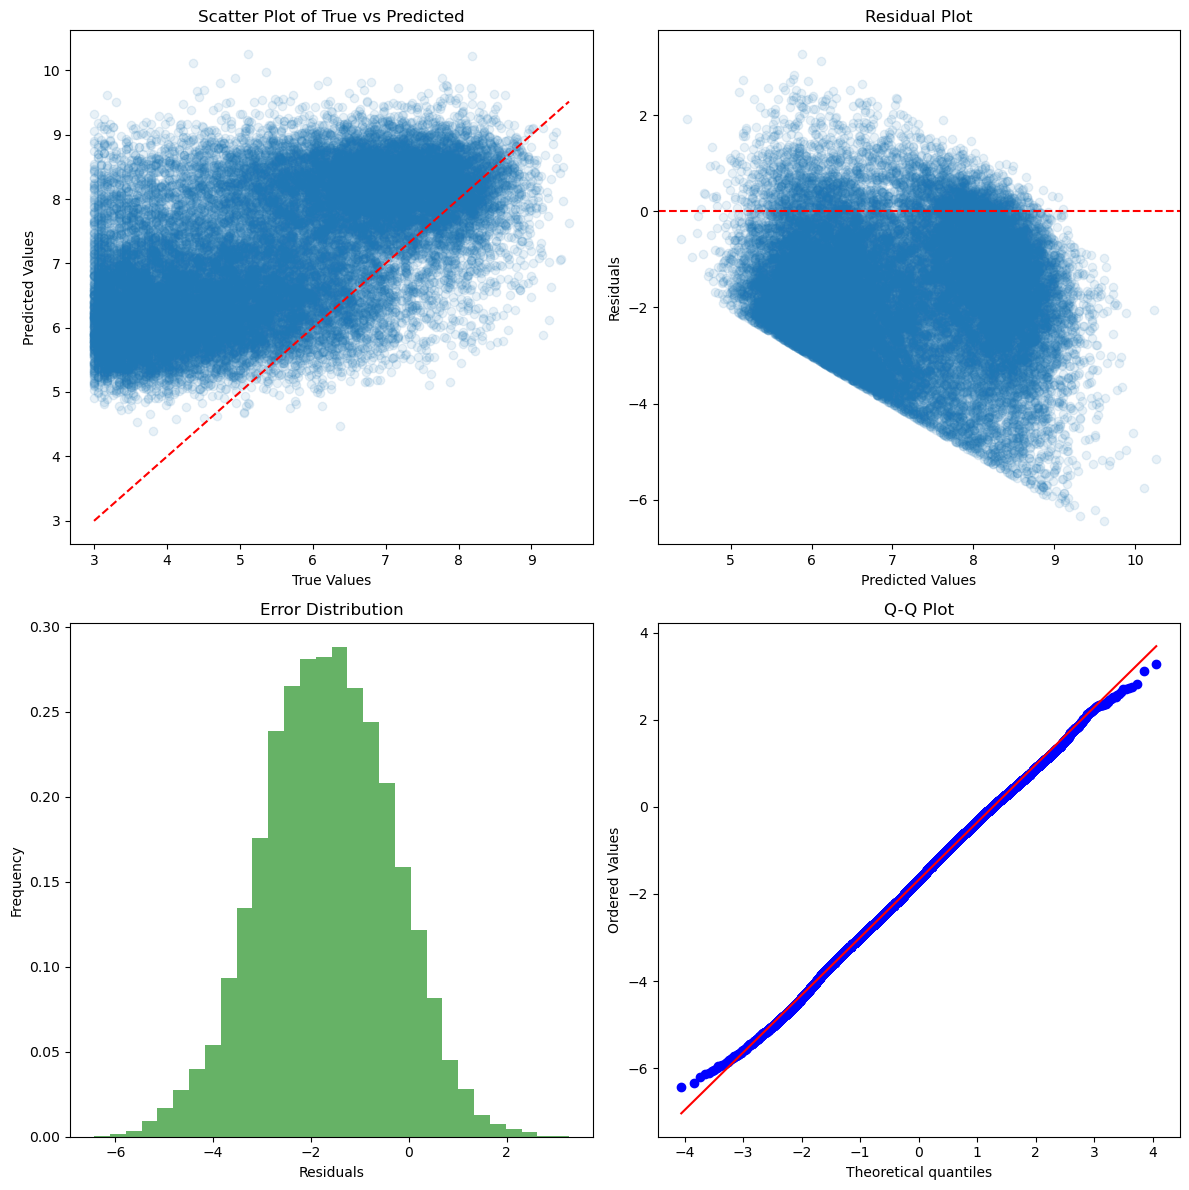

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 假设 y_test 是真实值，predictions 是预测值
residuals = targets - predictions
residuals = residuals.flatten()  # 将 residuals 转换为一维数组

# 创建 2x2 的子图（一个 2 行 2 列的布局）
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 绘制散点图
axes[0, 0].scatter(targets, predictions, alpha=0.1)
axes[0, 0].plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--')
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Scatter Plot of True vs Predicted')

# 绘制残差图
axes[0, 1].scatter(predictions, residuals, alpha=0.1)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# 绘制误差分布图
axes[1, 0].hist(residuals, bins=30, density=True, alpha=0.6, color='g')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution')

# 绘制 Q-Q 图
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# 调整布局
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

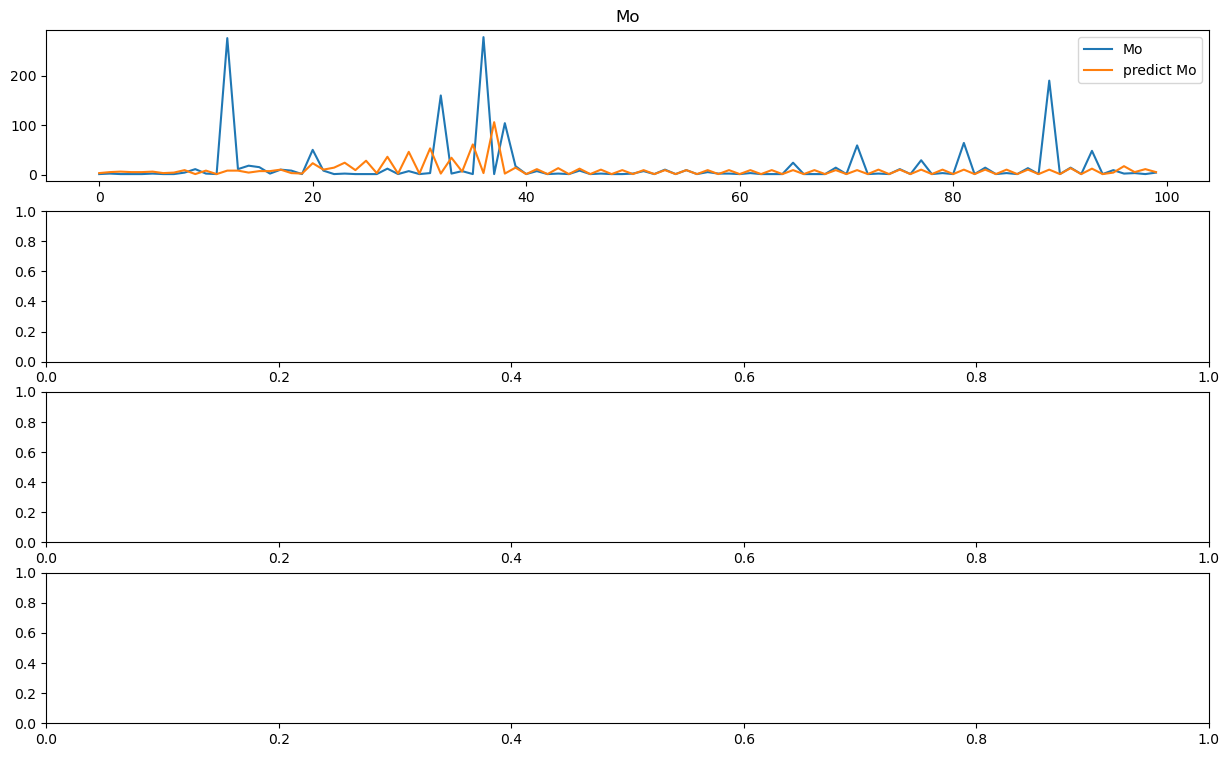

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
p_round = predictions.round()
t_round = y_test #targets.round()
p1 = p_round[start:end]
t1 = t_round[start:end]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:], label='Mo')
axs[0].plot(p1[:], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('state transition')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [140]:
t_round.shape

NameError: name 't_round' is not defined

In [151]:
dd = np.array(cy_data[0])
dd.shape

(464, 4)

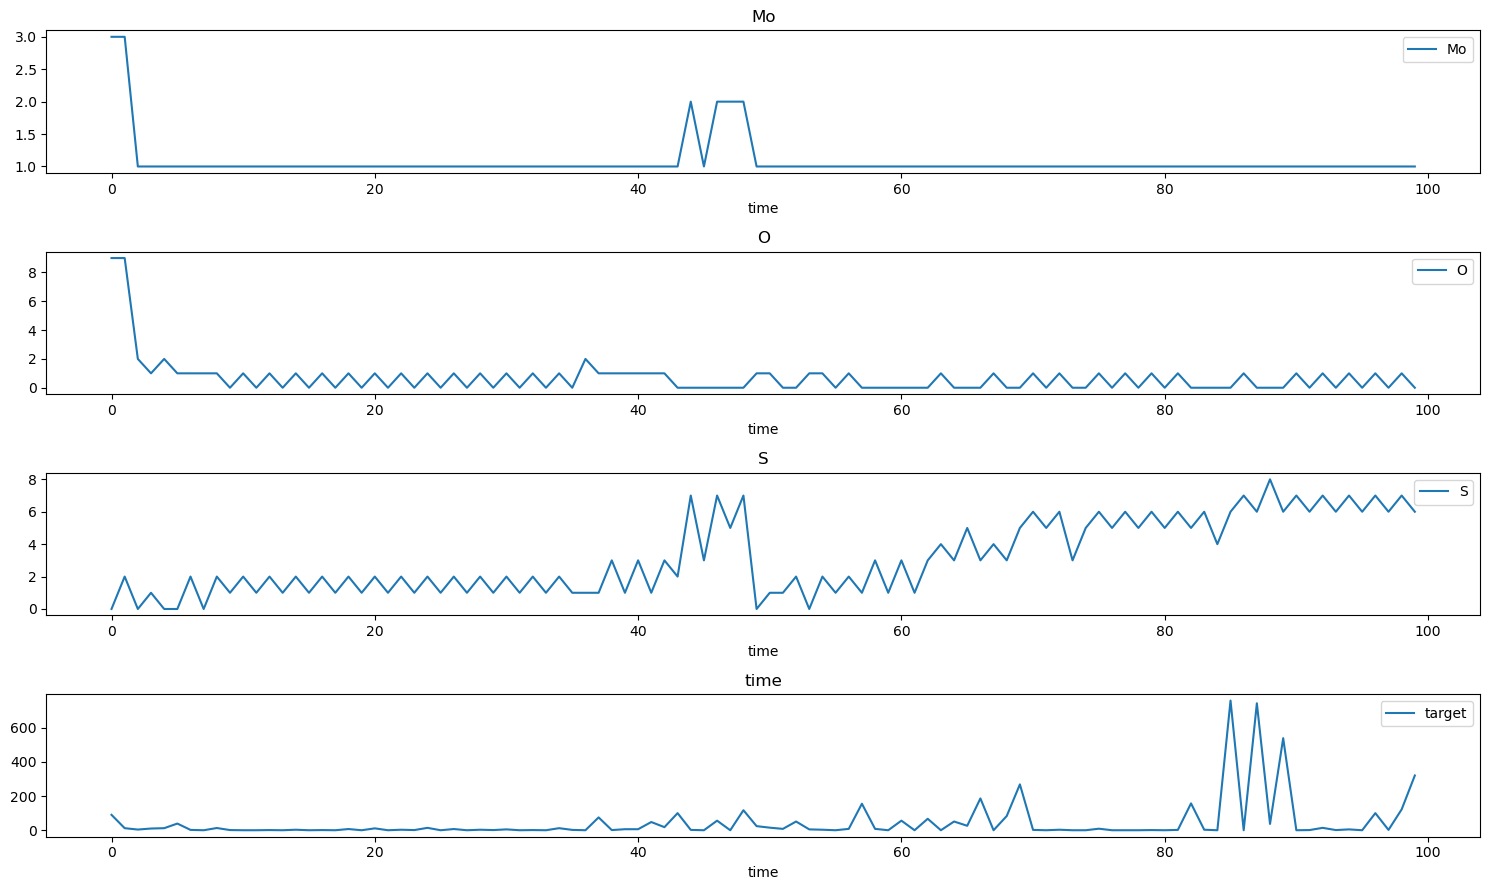

In [152]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = dd #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
# axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [1]:
import numpy as np
ss = np.load('../results/mul_T900_ss.npz')
ss_targets = ss['arr1']
ss_predictions = ss['arr2']

sts = np.load('../results/mul_T900_sts.npz')
sts_targets = sts['arr1']
sts_predictions = sts['arr2']

stst = np.load('../results/mul_T900_stst.npz')
stst_targets = stst['arr1']
stst_predictions = stst['arr2']

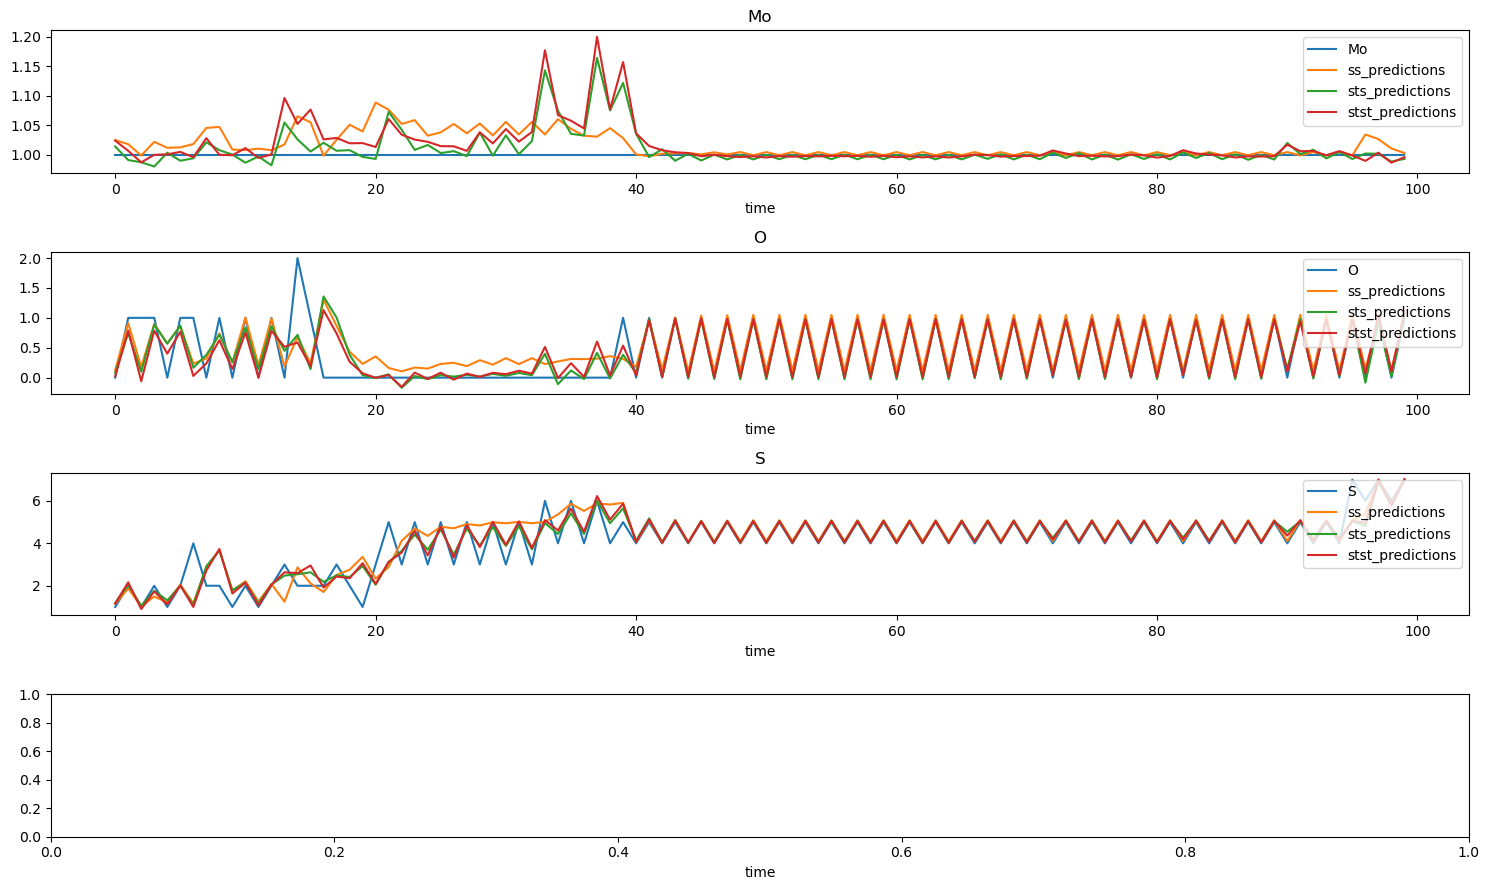

In [3]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = stst_targets #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(ss_predictions[start:end, 0], label='ss_predictions')
axs[0].plot(sts_predictions[start:end, 0], label='sts_predictions')
axs[0].plot(stst_predictions[start:end, 0], label='stst_predictions')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(ss_predictions[start:end, 1], label='ss_predictions')
axs[1].plot(sts_predictions[start:end, 1], label='sts_predictions')
axs[1].plot(stst_predictions[start:end, 1], label='stst_predictions')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(ss_predictions[start:end, 2], label='ss_predictions')
axs[2].plot(sts_predictions[start:end, 2], label='sts_predictions')
axs[2].plot(stst_predictions[start:end, 2], label='stst_predictions')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# # axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')